# libraries

In [ ]:
!pip install qnm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for qnm: filename=qnm-0.4.3-py3-none-any.whl size=95041 sha256=82762e289c564f4cd99f307289a238e0a0677493e55db763d285e7b38852ad3f
  Stored in directory: /root/.cache/pip/wheels/4e/59/56/7efc566d098d0136aedc92657a4f7d9099b866ae55f29c1788
Successfully built qnm


In [ ]:
# libraries
import os
import re
import time
import copy
import qnm # https://arxiv.org/abs/1908.10377
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
dtype=torch.float32
torch.set_default_dtype(dtype)
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, IterableDataset

# helpers

In [ ]:
class MyDataset(Dataset):
    def __init__(self):
        """
        dataset f(x)
        """
        self.x = None

    def __len__(self):
        return len(self.x[0])

    def __getitem__(self, idx):
        return self.x[idx]

    def get_full_item(self, idx):
        return self.x[idx][0], self.x[idx][1], self.x[idx][2], self.x[idx][3], self.x[idx][4], self.x[idx][5]

    def add_data_points(self, data):
        self.x = torch.from_numpy(data).type(dtype)

    def train_val_test_split(self):

        x_train, x_valtest, f_train, f_valtest = train_test_split(self.x[:, 0:1], self.x[:, 1:3], test_size=0.2, random_state=1234)
        x_val, x_test, f_val, f_test = train_test_split(x_valtest, f_valtest, test_size=0.5, random_state=1234)

        u_train, u_valtest, g_train, g_valtest = train_test_split(self.x[:, 3:4], self.x[:, 4:6], test_size=0.2, random_state=1234)
        u_val, u_test, g_val, g_test = train_test_split(u_valtest, g_valtest, test_size=0.5, random_state=1234)

        train = np.hstack((x_train, f_train[:, 0:1], f_train[:, 1:2], u_train, g_train[:, 0:1], g_train[:, 1:2]))
        val = np.hstack((x_val, f_val[:, 0:1], f_val[:, 1:2], u_val, g_val[:, 0:1], g_val[:, 1:2]))
        test = np.hstack((x_test, f_test[:, 0:1], f_test[:, 1:2], u_test, g_test[:, 0:1], g_test[:, 1:2]))

        return train, val, test

class Stan(torch.nn.Module):
    def __init__(self, D_hid):
        super().__init__()
        self.beta = torch.nn.Parameter(torch.ones(D_hid))
        self.output = D_hid

    def forward(self, x):
        if x.shape[-1] != self.beta.shape[-1]:
            raise ValueError(
                f"The last dimension of the input must be equal to the dimension of Stan parameters. Got inputs: {x.shape}, params: {self.beta.shape}"
            )
        return torch.tanh(x) * (torch.ones(self.output) + self.beta * x)

def dfx(x, f):
    return grad(f, x, grad_outputs=torch.ones(f.shape, dtype=dtype), create_graph=True)[0]


# pinns

In [ ]:
# physics-informed neural network

class kerr_pinn(torch.nn.Module):
    def __init__(self, D_hid):
        super(kerr_pinn,self).__init__()

        self.actF = Stan(D_hid)

        self.eigenvalues = torch.nn.Linear(4,4)
        self.Lin_1  = torch.nn.Linear(5, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)
        self.eigenfunctions = torch.nn.Linear(D_hid, 2)

    def forward(self, x, u):
        eigenvalues = self.eigenvalues(torch.cat((torch.abs(torch.ones_like(x)),
                                                   torch.abs(torch.ones_like(x)),
                                                   torch.abs(torch.ones_like(u)),
                                                   torch.zeros_like(u)), 1))

        L1 = self.Lin_1(torch.cat((x, eigenvalues), 1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        L3 = self.Lin_2(h2)
        h3 = self.actF(L3)
        f_ = self.eigenfunctions(h3)

        L_1 = self.Lin_1(torch.cat((u, eigenvalues), 1))
        h_1 = self.actF(L_1)
        L_2 = self.Lin_2(h_1)
        h_2 = self.actF(L_2)
        g_ = self.eigenfunctions(h_2)

        return f_, g_ , eigenvalues

#loss functions

In [ ]:
# loss functions

def kerr_loss_function(x, f1, f2, u, g1, g2, model, a, m, s):

    x = x.reshape(-1,1)
    x.requires_grad = True
    u = u.reshape(-1,1)
    u.requires_grad = True

    # PINN approximations

    f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
    g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
    omega1, omega2 = model(x, u)[2][:,0].reshape(-1,1), model(x, u)[2][:,1].reshape(-1,1)
    A1, A2 = model(x, u)[2][:,2].reshape(-1,1), model(x, u)[2][:,3].reshape(-1,1)

    # target data

    f = f1 + f2*1j
    g = g1 + g2*1j

    # derivatives

    f1_x, f2_x   = dfx(x, f1_), dfx(x, f2_)
    f1_xx, f2_xx = dfx(x, f1_x), dfx(x, f2_x)

    f_   = f1_ + f2_*1j
    f_x  = f1_x + f2_x*1j
    f_xx = f1_xx + f2_xx*1j

    g1_u, g2_u   = dfx(u, g1_), dfx(u, g2_)
    g1_uu, g2_uu = dfx(u, g1_u), dfx(u, g2_u)

    g_   = g1_ + g2_*1j
    g_u  = g1_u + g2_u*1j
    g_uu = g1_uu + g2_uu*1j

    # approximate QNMs

    omega = omega1.abs() - omega2.abs()*1j
    A = A1.abs() + A2.abs()*1j

    # radial

    r_p = (1 + ((1 - 4*(a**2))**(0.5)))/2
    F_0 = -(a**4)*(x**2)*(omega**2) - 2*(a**3)*m*(x**2)*omega + (a**2)*(-A*(x**2) + (x**2)*(4*(r_p + 1)*(omega**2) + 2*1j*(r_p + 2)*omega \
          + 2*1j*s*(omega + 1j) - 2) + x*(omega**2) - (omega**2)) + 2*a*m*(r_p*(x**2)*(2*omega + 1j) - x*(omega + 1j) - omega) + A*(x - 1) - 1j*r_p*(2*omega + 1j)*((x**2)*(s - 2*1j*omega + 1) - 2*(s + 1)*x + 2*1j*omega) + (s + 1)*(x - 2*1j*omega)
    F_1 = 2*(a**4)*(x**4)*(x - 1j*omega) - 2*1j*(a**3)*m*(x**4) + (a**2)*(x**2)*(2*r_p*(x**2)*(-1 + 2*1j*omega) - (s + 3)*(x**2) + 2*x*(s + 1j*omega + 2) - 4*1j*omega) + 2*1j*a*m*(x - 1)*(x**2) + (x - 1)*(2*r_p*(x**2)*(1 - 2*1j*omega) + (s + 1)*(x**2) - 2*(s + 1)*x + 2*1j*omega)
    F_2 = (a**4)*(x**6) - 2*(a**2)*(x - 1)*(x**4) + ((x - 1)**2)*(x**2)

    # angular

    G_0 = 4*(a**2)*((u**2) - 1)*(omega**2) - 4*a*((u**2) - 1)*omega*((u - 1)*abs(m - s) + (u + 1)*abs(m + s) + 2*(s + 1)*u) + 4*(A*((u**2) - 1) + (m**2) + 2*m*s*u + s*((s + 1)*(u**2) - 1)) - 2*((u**2) - 1)*abs(m + s) - 2*((u**2) - 1)*abs(m - s)*(abs(m + s) + 1) - ((u - 1)**2)*(abs(m - s)**2) - ((u + 1)**2)*(abs(m + s)**2)
    G_1 = -8*a*(((u**2) - 1)**2)*omega - 4*((u**2) - 1)*((u - 1)*abs(m - s) + (u + 1)*abs(m + s) + 2*u)
    G_2 = -4*(((u**2) - 1)**2)

    # ODE losses

    L_radial_ODE = torch.mean(((F_2*f_xx + F_1*f_x + F_0*f_).abs())**2)
    L_angular_ODE = torch.mean(((G_2*g_uu + G_1*g_u + G_0*g_).abs())**2)

    # mean-square error loss crucial part of supervised-learning:
    L_MSE = torch.mean(((f - f_).abs())**2) + torch.mean(((g - g_).abs())**2)

    Loss = L_radial_ODE + L_angular_ODE + L_MSE

    return Loss, L_MSE, omega1, omega2, A1, A2


#training loop

In [ ]:
# training loop

def run_eigenvalue_solver(dataset, a, ell, m, n, s, epsilon, neurons, epochs, learning_rate, omega, A, metric="kerr"):

    train_loss, val_loss, omega1, omega2, err1, err2, A1, A2, err3, err4 = [], [], [], [], [], [], [], [], [], []

    start_time = time.time()

    print("targets: omega: %.6f - %.6f i; A: %.6f + %.6f i\n" %(abs(omega.real),
                                                                abs(omega.imag),
                                                                abs(A.real),
                                                                abs(A.imag)))

    # load data

    radial_and_angular_data = MyDataset()

    radial_and_angular_data.add_data_points(dataset)

    train_data, val_data, test_data = radial_and_angular_data.train_val_test_split()

    # example f(x = x_0) and g(u = u_0)

    x_0, f1_x0, f2_x0, u_0, g1_u0, g2_u0 = radial_and_angular_data.get_full_item(0)

    print("\n f(x = x_0) and g(u = u_0);\n f(x = %.3f) = (%.3f, %.3f);\n g(u = %.3f) = (%.3f, %.3f);\n"
          %(x_0, f1_x0, f2_x0, u_0, g1_u0, g2_u0))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = 32

    train_dataloader = DataLoader(dataset = train_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    val_dataloader = DataLoader(dataset = val_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    test_dataloader = DataLoader(dataset = test_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    model = kerr_pinn(neurons)
    betas = [0.999, 0.9999]
    optimiser = optim.Adam(model.parameters(), lr=learning_rate, betas = betas)

    start_time = time.time()

    for epoch in tqdm(range(epochs), leave=False):

        running_train_loss = 0.0
        running_val_loss = 0.0

        model.train()
        for data in train_dataloader:
            model.zero_grad()
            optimiser.zero_grad()

            x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]

            L_total, L_MSE, omega1_, omega2_, A1_, A2_ = kerr_loss_function(x, f1, f2, u, g1, g2, model, a, m, s)

            L_total.backward(retain_graph = False);
            optimiser.step()
            optimiser.zero_grad()

            omega1.append(abs(omega1_[0].data.tolist()[0]))
            omega2.append(abs(omega2_[0].data.tolist()[0]))
            err1_ = (((abs(omega1_) - abs(omega.real))/abs(omega.real))*100).mean()
            err2_ = (((abs(omega2_) - abs(omega.imag))/abs(omega.imag))*100).mean()
            err1.append(err1_.data.tolist())
            err2.append(err2_.data.tolist())

            A1.append(abs(A1_[0].data.tolist()[0]))
            A2.append(abs(A2_[0].data.tolist()[0]))
            err3_ = (((abs(A1_) - abs(A.real))/abs(A.real))*100).mean()
            err4_ = ((((abs(A2_) + 1) - abs(A.imag + 1))/abs(A.imag + 1))*100).mean()
            err3.append(err3_.data.tolist())
            err4.append(err4_.data.tolist())

            running_train_loss += L_MSE.data.numpy() * data.size(0)

        model.eval()
        for data in val_dataloader:

            x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]
            f = f1 + f2*1j
            g = g1 + g2*1j

            x = x.reshape(-1,1)
            x.requires_grad = False
            u = u.reshape(-1,1)
            u.requires_grad = False
            f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
            g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
            f_ = f1_ + f2_*1j
            g_ = g1_ + g2_*1j

            L_MSE = torch.mean(((f - f_).abs())**2) + torch.mean(((g - g_).abs())**2)

            running_val_loss += L_MSE.data.numpy() * data.size(0)

        avg_train_loss = running_train_loss / len(train_dataloader.dataset)
        avg_val_loss = running_val_loss / len(test_dataloader.dataset)

        train_loss.append(avg_train_loss)
        val_loss.append(avg_val_loss)

        if epoch % 100 == 0 and epoch > 0:
            print('train loss: %.8f , val loss: %.8f; omega: %.8f %.8f i. error: %.4f , %.4f . A: %.8f %.8f i. error: %.4f , %.4f .'
            %(avg_train_loss,
              avg_val_loss,
              omega1[-1], omega2[-1],
              err1[-1], err2[-1],
              A1[-1], A2[-1],
              err3[-1], err4[-1]))


    end_time = time.time()
    runtime = end_time - start_time

    # test

    model.eval()
    for data in test_dataloader:

        x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]
        f = f1 + f2*1j
        g = g1 + g2*1j

        x = x.reshape(-1,1)
        x.requires_grad = False
        u = u.reshape(-1,1)
        u.requires_grad = False
        f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
        g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
        f_ = f1_ + f2_*1j
        g_ = g1_ + g2_*1j

        deltaf = (torch.sqrt(torch.mean(((f - f_).abs())**2)) / torch.sqrt(torch.mean(((f).abs())**2)))
        deltag = (torch.sqrt(torch.mean(((g - g_).abs())**2)) / torch.sqrt(torch.mean(((g).abs())**2)))

        RMSE = (deltaf + deltag)/2

        acc = (1 - RMSE)*100

    approx_hists = (train_loss, val_loss, omega1, omega2, err1, err2, A1, A2, err3, err4, acc)

    return approx_hists, runtime


# run training

In [ ]:
### run main process

from google.colab import drive
drive.mount('/content/gdrive')

metric = "kerr"

neurons, epochs, learning_rate = 20, int(5e3), 2e-3

s = -2
a = [0.1, 0.2, 0.3, 0.4]
ell = [2.0]
m = [0.0]
n = [0.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

train_loss_dict, val_loss_dict, omega1_dict, omega2_dict, err1_dict, err2_dict = dict(), dict(), dict(), dict(), dict(), dict()
A1_dict, A2_dict, err3_dict, err4_dict, acc_dict, runtime_dict =  dict(), dict(), dict(), dict(), dict(), dict()

for i in range(len(mode)):

    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    print("\nspin sequence: s=%s, a=%s, ell=%s, m=%s, n=%s" %(s, a, ell, m, n))

    radial_component = ['R_a%sell%sm%sn%s.csv'%(a, ell, m, n)]
    radial_component = [np.loadtxt('gdrive/MyDrive/qnm_data/Kerr/'+f,delimiter=',') for f in radial_component]

    spheroidal_harmonics = ['S_a%sell%sm%sn%s.csv'%(a, ell, m, n)]
    spheroidal_harmonics = [np.loadtxt('gdrive/MyDrive/qnm_data/Kerr/'+f,delimiter=',') for f in spheroidal_harmonics]
    np.random.shuffle(spheroidal_harmonics[0])

    # balancing data

    balance = min(len(spheroidal_harmonics[0]), len(radial_component[0]))

    radial_component[0] = radial_component[0][0:balance]

    spheroidal_harmonics[0] = spheroidal_harmonics[0][0:balance]

    print("\nsize of radial data %.0f; size of angular data %.0f"%(len(radial_component[0]),len(spheroidal_harmonics[0])))

    # concatenate data

    dataset = np.concatenate((radial_component[0], spheroidal_harmonics[0]), axis=1)

    # QNMs from https://arxiv.org/abs/1908.10377

    spin_sequence_slmn = qnm.modes_cache(s=int(s), l=int(ell), m=int(m), n=int(n))
    omega_, A_, _ = spin_sequence_slmn(a=a*2)

    omega = abs(float(omega_.real)*2) - abs(float(omega_.imag)*2)*1j
    A = abs(float(A_.real)) + abs(float(A_.imag))*1j

    # training

    approx_hists, runtime = run_eigenvalue_solver(dataset,
                                                  a, ell, m, n , s,
                                                  None,
                                                  neurons, epochs, learning_rate,
                                                  omega, A, metric)

    print("\nruntime: %.0f minutes" %(runtime/60))

    train_loss_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[0]})
    val_loss_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[1]})
    omega1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[2]})
    omega2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[3]})
    err1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[4]})
    err2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[5]})
    A1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[6]})
    A2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[7]})
    err3_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[8]})
    err4_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[9]})
    acc_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[10]})
    runtime_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): runtime})

Mounted at /content/gdrive

spin sequence: s=-2, a=0.1, ell=2.0, m=0.0, n=0.0

size of radial data 900; size of angular data 900
targets: omega: 0.750248 - 0.177401 i; A: 3.997216 + 0.001395 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (0.467, -0.357);
 g(u = -0.466) = (0.987, 0.003);



  2%|▏         | 101/5000 [01:21<1:10:33,  1.16it/s]

train loss: 0.96663224 , val loss: 0.96787982; omega: 0.15039234 0.27962217 i. error: -79.9543 , 57.6217 . A: 1.00863051 0.11140653 i. error: -74.7667 , 10.9859 .


  4%|▍         | 201/5000 [02:38<1:08:27,  1.17it/s]

train loss: 0.94246400 , val loss: 0.94662502; omega: 0.35349506 0.19944324 i. error: -52.8829 , 12.4252 . A: 0.92771983 0.04231476 i. error: -76.7908 , 4.0863 .


  6%|▌         | 301/5000 [03:54<56:41,  1.38it/s]

train loss: 0.92187130 , val loss: 0.92451609; omega: 0.39090723 0.16260979 i. error: -47.8963 , -8.3376 . A: 1.33795094 0.03938067 i. error: -66.5279 , 3.7933 .


  8%|▊         | 401/5000 [05:10<1:02:33,  1.23it/s]

train loss: 0.87531592 , val loss: 0.87711223; omega: 0.56262106 0.17341802 i. error: -25.0086 , -2.2451 . A: 2.36032915 0.02488839 i. error: -40.9507 , 2.3461 .


 10%|█         | 501/5000 [06:27<1:00:57,  1.23it/s]

train loss: 0.00625856 , val loss: 0.00524777; omega: 0.75196928 0.23690820 i. error: 0.2294 , 33.5440 . A: 4.06202793 0.01758369 i. error: 1.6214 , 1.6166 .


 12%|█▏        | 601/5000 [07:49<1:09:13,  1.06it/s]

train loss: 0.00202738 , val loss: 0.00213931; omega: 0.74918622 0.20863593 i. error: -0.1415 , 17.6071 . A: 4.02018213 0.00040751 i. error: 0.5745 , -0.0986 .


 14%|█▍        | 701/5000 [09:04<47:36,  1.50it/s]

train loss: 0.00109687 , val loss: 0.00111644; omega: 0.74881011 0.19796246 i. error: -0.1916 , 11.5905 . A: 3.98932600 0.00054833 i. error: -0.1974 , -0.0845 .


 16%|█▌        | 801/5000 [10:20<1:06:36,  1.05it/s]

train loss: 0.00005919 , val loss: 0.00005635; omega: 0.75165707 0.16985023 i. error: 0.1878 , -4.2562 . A: 3.99953318 0.00201697 i. error: 0.0580 , 0.0621 .


 18%|█▊        | 901/5000 [11:34<47:12,  1.45it/s]

train loss: 0.00000663 , val loss: 0.00000693; omega: 0.75055885 0.17527753 i. error: 0.0414 , -1.1969 . A: 3.99739552 0.00128952 i. error: 0.0045 , -0.0105 .


 20%|██        | 1001/5000 [12:50<58:34,  1.14it/s]

train loss: 0.00000174 , val loss: 0.00000151; omega: 0.74984384 0.17587489 i. error: -0.0539 , -0.8602 . A: 3.99736929 0.00139803 i. error: 0.0038 , 0.0003 .


 22%|██▏       | 1101/5000 [14:05<43:45,  1.48it/s]

train loss: 0.00000182 , val loss: 0.00000158; omega: 0.75004649 0.17587532 i. error: -0.0268 , -0.8599 . A: 3.99725723 0.00135679 i. error: 0.0010 , -0.0038 .


 24%|██▍       | 1201/5000 [15:20<51:33,  1.23it/s]

train loss: 0.00000166 , val loss: 0.00000151; omega: 0.74992353 0.17570607 i. error: -0.0432 , -0.9553 . A: 3.99721384 0.00135256 i. error: -0.0001 , -0.0042 .


 26%|██▌       | 1301/5000 [16:36<43:22,  1.42it/s]

train loss: 0.00000161 , val loss: 0.00000145; omega: 0.75003505 0.17552260 i. error: -0.0284 , -1.0587 . A: 3.99720764 0.00137893 i. error: -0.0002 , -0.0016 .


 28%|██▊       | 1401/5000 [17:50<41:17,  1.45it/s]

train loss: 0.00000153 , val loss: 0.00000148; omega: 0.75009972 0.17562026 i. error: -0.0198 , -1.0037 . A: 3.99721456 0.00140632 i. error: -0.0000 , 0.0012 .


 30%|███       | 1501/5000 [19:06<43:19,  1.35it/s]

train loss: 0.00000139 , val loss: 0.00000133; omega: 0.75011426 0.17557207 i. error: -0.0178 , -1.0309 . A: 3.99722862 0.00134318 i. error: 0.0003 , -0.0052 .


 32%|███▏      | 1601/5000 [20:20<38:21,  1.48it/s]

train loss: 0.00000144 , val loss: 0.00000133; omega: 0.75019252 0.17565989 i. error: -0.0074 , -0.9813 . A: 3.99721575 0.00143182 i. error: -0.0000 , 0.0037 .


 34%|███▍      | 1701/5000 [21:35<46:42,  1.18it/s]

train loss: 0.00000101 , val loss: 0.00000092; omega: 0.75018179 0.17557389 i. error: -0.0088 , -1.0298 . A: 3.99720240 0.00136000 i. error: -0.0003 , -0.0035 .


 36%|███▌      | 1801/5000 [22:49<38:16,  1.39it/s]

train loss: 0.00000085 , val loss: 0.00000080; omega: 0.75033838 0.17572477 i. error: 0.0121 , -0.9448 . A: 3.99721575 0.00142818 i. error: -0.0000 , 0.0033 .


 38%|███▊      | 1901/5000 [24:04<42:46,  1.21it/s]

train loss: 0.00000066 , val loss: 0.00000064; omega: 0.75026578 0.17576697 i. error: 0.0024 , -0.9210 . A: 3.99721146 0.00140578 i. error: -0.0001 , 0.0011 .


 40%|████      | 2001/5000 [25:19<34:59,  1.43it/s]

train loss: 0.00000052 , val loss: 0.00000049; omega: 0.75041527 0.17586654 i. error: 0.0223 , -0.8649 . A: 3.99722576 0.00134380 i. error: 0.0002 , -0.0051 .


 42%|████▏     | 2101/5000 [26:32<31:38,  1.53it/s]

train loss: 0.00000048 , val loss: 0.00000038; omega: 0.75047874 0.17590095 i. error: 0.0308 , -0.8455 . A: 3.99721479 0.00135786 i. error: -0.0000 , -0.0037 .


 44%|████▍     | 2201/5000 [27:47<36:06,  1.29it/s]

train loss: 0.00000031 , val loss: 0.00000026; omega: 0.75048161 0.17610091 i. error: 0.0312 , -0.7327 . A: 3.99721003 0.00133450 i. error: -0.0002 , -0.0060 .


 46%|████▌     | 2301/5000 [29:01<30:56,  1.45it/s]

train loss: 0.00000024 , val loss: 0.00000025; omega: 0.75057036 0.17600736 i. error: 0.0430 , -0.7855 . A: 3.99722147 0.00137311 i. error: 0.0001 , -0.0022 .


 48%|████▊     | 2401/5000 [30:15<37:24,  1.16it/s]

train loss: 0.00000033 , val loss: 0.00000025; omega: 0.75057572 0.17612115 i. error: 0.0437 , -0.7213 . A: 3.99721050 0.00134567 i. error: -0.0001 , -0.0049 .


 50%|█████     | 2501/5000 [31:30<31:40,  1.32it/s]

train loss: 0.00000026 , val loss: 0.00000014; omega: 0.75059080 0.17619167 i. error: 0.0457 , -0.6816 . A: 3.99722624 0.00139557 i. error: 0.0003 , 0.0001 .


 52%|█████▏    | 2601/5000 [32:45<30:22,  1.32it/s]

train loss: 0.00000012 , val loss: 0.00000012; omega: 0.75058573 0.17627825 i. error: 0.0450 , -0.6328 . A: 3.99721956 0.00138135 i. error: 0.0001 , -0.0013 .


 54%|█████▍    | 2701/5000 [33:59<27:21,  1.40it/s]

train loss: 0.00000009 , val loss: 0.00000010; omega: 0.75063425 0.17630336 i. error: 0.0515 , -0.6186 . A: 3.99720430 0.00142212 i. error: -0.0003 , 0.0027 .


 56%|█████▌    | 2801/5000 [35:13<24:22,  1.50it/s]

train loss: 0.00000007 , val loss: 0.00000007; omega: 0.75060755 0.17633072 i. error: 0.0479 , -0.6032 . A: 3.99718904 0.00136128 i. error: -0.0007 , -0.0033 .


 58%|█████▊    | 2901/5000 [36:29<27:50,  1.26it/s]

train loss: 0.00000019 , val loss: 0.00000022; omega: 0.75054044 0.17639112 i. error: 0.0390 , -0.5692 . A: 3.99724197 0.00132997 i. error: 0.0006 , -0.0065 .


 60%|██████    | 3001/5000 [37:44<22:00,  1.51it/s]

train loss: 0.00000010 , val loss: 0.00000009; omega: 0.75055039 0.17648056 i. error: 0.0403 , -0.5187 . A: 3.99721813 0.00139362 i. error: 0.0000 , -0.0001 .


 62%|██████▏   | 3101/5000 [39:02<23:40,  1.34it/s]

train loss: 0.00000008 , val loss: 0.00000007; omega: 0.75061500 0.17640296 i. error: 0.0489 , -0.5625 . A: 3.99716520 0.00140730 i. error: -0.0013 , 0.0012 .


 64%|██████▍   | 3201/5000 [40:16<21:01,  1.43it/s]

train loss: 0.00000008 , val loss: 0.00000008; omega: 0.75062871 0.17641234 i. error: 0.0508 , -0.5572 . A: 3.99721575 0.00132671 i. error: -0.0000 , -0.0068 .


 66%|██████▌   | 3301/5000 [41:31<25:03,  1.13it/s]

train loss: 0.00000010 , val loss: 0.00000006; omega: 0.75068218 0.17646240 i. error: 0.0579 , -0.5290 . A: 3.99717760 0.00138324 i. error: -0.0010 , -0.0012 .


 68%|██████▊   | 3401/5000 [42:44<17:59,  1.48it/s]

train loss: 0.00000008 , val loss: 0.00000007; omega: 0.75057238 0.17642976 i. error: 0.0433 , -0.5474 . A: 3.99719715 0.00141526 i. error: -0.0005 , 0.0020 .


 70%|███████   | 3501/5000 [43:58<18:16,  1.37it/s]

train loss: 0.00000017 , val loss: 0.00000008; omega: 0.75062031 0.17658260 i. error: 0.0496 , -0.4612 . A: 3.99701548 0.00138445 i. error: -0.0050 , -0.0010 .


 72%|███████▏  | 3601/5000 [45:14<16:35,  1.41it/s]

train loss: 0.00000010 , val loss: 0.00000012; omega: 0.75058854 0.17643769 i. error: 0.0454 , -0.5429 . A: 3.99725103 0.00139109 i. error: 0.0009 , -0.0004 .


 74%|███████▍  | 3701/5000 [46:28<15:07,  1.43it/s]

train loss: 0.00000014 , val loss: 0.00000007; omega: 0.75071728 0.17651999 i. error: 0.0626 , -0.4965 . A: 3.99721670 0.00136830 i. error: 0.0000 , -0.0026 .


 76%|███████▌  | 3801/5000 [47:43<14:53,  1.34it/s]

train loss: 0.00000010 , val loss: 0.00000012; omega: 0.75076950 0.17642984 i. error: 0.0695 , -0.5473 . A: 3.99721289 0.00136311 i. error: -0.0001 , -0.0032 .


 78%|███████▊  | 3901/5000 [48:58<12:39,  1.45it/s]

train loss: 0.00000024 , val loss: 0.00000032; omega: 0.75079972 0.17656487 i. error: 0.0736 , -0.4712 . A: 3.99717951 0.00145232 i. error: -0.0009 , 0.0057 .


 80%|████████  | 4001/5000 [50:14<13:34,  1.23it/s]

train loss: 0.00000014 , val loss: 0.00000013; omega: 0.75061446 0.17652737 i. error: 0.0489 , -0.4924 . A: 3.99715376 0.00138014 i. error: -0.0016 , -0.0015 .


 82%|████████▏ | 4101/5000 [51:31<10:08,  1.48it/s]

train loss: 0.00000024 , val loss: 0.00000033; omega: 0.75059181 0.17649832 i. error: 0.0458 , -0.5087 . A: 3.99730587 0.00131217 i. error: 0.0022 , -0.0082 .


 84%|████████▍ | 4201/5000 [52:47<09:51,  1.35it/s]

train loss: 0.00000029 , val loss: 0.00000018; omega: 0.75076210 0.17642187 i. error: 0.0685 , -0.5518 . A: 3.99718428 0.00124898 i. error: -0.0008 , -0.0146 .


 86%|████████▌ | 4301/5000 [54:03<08:51,  1.32it/s]

train loss: 0.00000015 , val loss: 0.00000018; omega: 0.75059736 0.17652008 i. error: 0.0466 , -0.4965 . A: 3.99726486 0.00137857 i. error: 0.0012 , -0.0016 .


 88%|████████▊ | 4401/5000 [55:20<07:23,  1.35it/s]

train loss: 0.00000015 , val loss: 0.00000010; omega: 0.75064635 0.17648602 i. error: 0.0531 , -0.5157 . A: 3.99718666 0.00135130 i. error: -0.0007 , -0.0043 .


 90%|█████████ | 4501/5000 [56:35<07:02,  1.18it/s]

train loss: 0.00000042 , val loss: 0.00000044; omega: 0.75069016 0.17642370 i. error: 0.0589 , -0.5508 . A: 3.99726057 0.00138844 i. error: 0.0011 , -0.0006 .


 92%|█████████▏| 4601/5000 [57:52<04:51,  1.37it/s]

train loss: 0.00000017 , val loss: 0.00000016; omega: 0.75069910 0.17658979 i. error: 0.0601 , -0.4572 . A: 3.99722338 0.00126560 i. error: 0.0002 , -0.0129 .


 94%|█████████▍| 4701/5000 [59:08<04:28,  1.12it/s]

train loss: 0.00000013 , val loss: 0.00000020; omega: 0.75058001 0.17658079 i. error: 0.0443 , -0.4622 . A: 3.99722219 0.00130113 i. error: 0.0001 , -0.0093 .


 96%|█████████▌| 4801/5000 [1:00:23<02:17,  1.45it/s]

train loss: 0.00000057 , val loss: 0.00000020; omega: 0.75106859 0.17667979 i. error: 0.1094 , -0.4064 . A: 3.99732161 0.00116226 i. error: 0.0026 , -0.0232 .


 98%|█████████▊| 4901/5000 [1:01:40<01:33,  1.06it/s]

train loss: 0.00000225 , val loss: 0.00000115; omega: 0.75026119 0.17647284 i. error: 0.0018 , -0.5231 . A: 3.99726462 0.00146409 i. error: 0.0012 , 0.0069 .



runtime: 63 minutes

spin sequence: s=-2, a=0.2, ell=2.0, m=0.0, n=0.0

size of radial data 900; size of angular data 900
targets: omega: 0.759363 - 0.175653 i; A: 3.988560 + 0.005596 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (0.441, -0.369);
 g(u = -0.751) = (0.987, 0.003);



  2%|▏         | 101/5000 [01:17<1:04:47,  1.26it/s]

train loss: 0.91002572 , val loss: 0.90724241; omega: 0.13483417 0.11274427 i. error: -82.2438 , -35.8143 . A: 0.44846290 0.12427593 i. error: -88.7563 , 11.8020 .


  4%|▍         | 201/5000 [02:32<54:19,  1.47it/s]

train loss: 0.87643851 , val loss: 0.87564645; omega: 0.40768862 0.13299721 i. error: -46.3118 , -24.2842 . A: 1.33987486 0.10999371 i. error: -66.4070 , 10.3817 .


  6%|▌         | 301/5000 [03:49<1:02:16,  1.26it/s]

train loss: 0.00353452 , val loss: 0.00565454; omega: 0.76626420 0.23084305 i. error: 0.9088 , 31.4198 . A: 4.03277969 0.01403368 i. error: 1.1087 , 0.8391 .


  8%|▊         | 401/5000 [05:04<54:22,  1.41it/s]

train loss: 0.00030877 , val loss: 0.00022862; omega: 0.76238632 0.19109309 i. error: 0.3981 , 8.7900 . A: 4.00101805 0.00323680 i. error: 0.3124 , -0.2346 .


 10%|█         | 501/5000 [06:20<1:00:48,  1.23it/s]

train loss: 0.00018938 , val loss: 0.00017567; omega: 0.76222444 0.18143481 i. error: 0.3768 , 3.2915 . A: 3.98704934 0.00554930 i. error: -0.0379 , -0.0046 .


 12%|█▏        | 601/5000 [07:35<52:04,  1.41it/s]

train loss: 0.00002301 , val loss: 0.00002197; omega: 0.76268125 0.17580086 i. error: 0.4370 , 0.0841 . A: 3.98902416 0.00600499 i. error: 0.0117 , 0.0407 .


 14%|█▍        | 701/5000 [08:52<54:45,  1.31it/s]

train loss: 0.00000875 , val loss: 0.00000766; omega: 0.76239169 0.17411374 i. error: 0.3988 , -0.8764 . A: 3.98842263 0.00575931 i. error: -0.0034 , 0.0163 .


 16%|█▌        | 801/5000 [10:08<48:16,  1.45it/s]

train loss: 0.00000374 , val loss: 0.00000345; omega: 0.76211894 0.17267253 i. error: 0.3629 , -1.6969 . A: 3.98862314 0.00555147 i. error: 0.0016 , -0.0044 .


 18%|█▊        | 901/5000 [11:24<51:18,  1.33it/s]

train loss: 0.00000237 , val loss: 0.00000193; omega: 0.76186275 0.17186256 i. error: 0.3292 , -2.1580 . A: 3.98847103 0.00545731 i. error: -0.0022 , -0.0138 .


 20%|██        | 1001/5000 [12:40<45:38,  1.46it/s]

train loss: 0.00000183 , val loss: 0.00000172; omega: 0.76173025 0.17146108 i. error: 0.3117 , -2.3865 . A: 3.98845172 0.00545360 i. error: -0.0027 , -0.0142 .


 22%|██▏       | 1101/5000 [13:57<48:36,  1.34it/s]

train loss: 0.00000186 , val loss: 0.00000190; omega: 0.76164871 0.17135245 i. error: 0.3010 , -2.4484 . A: 3.98845530 0.00546825 i. error: -0.0026 , -0.0127 .


 24%|██▍       | 1201/5000 [15:12<47:46,  1.33it/s]

train loss: 0.00000195 , val loss: 0.00000174; omega: 0.76165605 0.17139202 i. error: 0.3019 , -2.4259 . A: 3.98845315 0.00547914 i. error: -0.0027 , -0.0116 .


 26%|██▌       | 1301/5000 [16:28<44:45,  1.38it/s]

train loss: 0.00000184 , val loss: 0.00000176; omega: 0.76159823 0.17131217 i. error: 0.2943 , -2.4713 . A: 3.98846006 0.00547312 i. error: -0.0025 , -0.0122 .


 28%|██▊       | 1401/5000 [17:44<44:23,  1.35it/s]

train loss: 0.00000181 , val loss: 0.00000179; omega: 0.76164901 0.17139482 i. error: 0.3010 , -2.4243 . A: 3.98845100 0.00550662 i. error: -0.0027 , -0.0089 .


 30%|███       | 1501/5000 [19:00<41:18,  1.41it/s]

train loss: 0.00000197 , val loss: 0.00000173; omega: 0.76163280 0.17145252 i. error: 0.2989 , -2.3914 . A: 3.98844790 0.00548501 i. error: -0.0028 , -0.0110 .


 32%|███▏      | 1601/5000 [20:17<48:46,  1.16it/s]

train loss: 0.00000231 , val loss: 0.00000251; omega: 0.76156616 0.17139828 i. error: 0.2901 , -2.4223 . A: 3.98846650 0.00553353 i. error: -0.0023 , -0.0062 .


 34%|███▍      | 1701/5000 [21:32<40:08,  1.37it/s]

train loss: 0.00000179 , val loss: 0.00000165; omega: 0.76160997 0.17142826 i. error: 0.2959 , -2.4052 . A: 3.98845673 0.00545627 i. error: -0.0026 , -0.0139 .


 36%|███▌      | 1801/5000 [22:48<46:29,  1.15it/s]

train loss: 0.00000189 , val loss: 0.00000174; omega: 0.76170391 0.17131275 i. error: 0.3082 , -2.4710 . A: 3.98844481 0.00550166 i. error: -0.0029 , -0.0094 .


 38%|███▊      | 1901/5000 [24:04<37:08,  1.39it/s]

train loss: 0.00000163 , val loss: 0.00000167; omega: 0.76151097 0.17144552 i. error: 0.2828 , -2.3954 . A: 3.98844576 0.00542492 i. error: -0.0029 , -0.0170 .


 40%|████      | 2001/5000 [25:21<48:14,  1.04it/s]

train loss: 0.00000357 , val loss: 0.00000384; omega: 0.76153749 0.17141372 i. error: 0.2863 , -2.4135 . A: 3.98846841 0.00548385 i. error: -0.0023 , -0.0111 .


 42%|████▏     | 2101/5000 [26:36<34:25,  1.40it/s]

train loss: 0.00000554 , val loss: 0.00000188; omega: 0.76137167 0.17157106 i. error: 0.2645 , -2.3239 . A: 3.98843169 0.00532323 i. error: -0.0032 , -0.0271 .


 44%|████▍     | 2201/5000 [27:53<39:54,  1.17it/s]

train loss: 0.00000185 , val loss: 0.00000193; omega: 0.76148343 0.17154899 i. error: 0.2792 , -2.3365 . A: 3.98845410 0.00568435 i. error: -0.0026 , 0.0088 .


 46%|████▌     | 2301/5000 [29:08<30:52,  1.46it/s]

train loss: 0.00000183 , val loss: 0.00000156; omega: 0.76158071 0.17141724 i. error: 0.2920 , -2.4115 . A: 3.98847675 0.00543515 i. error: -0.0021 , -0.0160 .


 48%|████▊     | 2401/5000 [30:23<38:00,  1.14it/s]

train loss: 0.00000269 , val loss: 0.00000197; omega: 0.76143909 0.17159769 i. error: 0.2734 , -2.3088 . A: 3.98846006 0.00550395 i. error: -0.0025 , -0.0092 .


 50%|█████     | 2501/5000 [31:39<30:17,  1.38it/s]

train loss: 0.00000214 , val loss: 0.00000263; omega: 0.76157212 0.17156886 i. error: 0.2909 , -2.3252 . A: 3.98844290 0.00545710 i. error: -0.0029 , -0.0138 .


 52%|█████▏    | 2601/5000 [32:56<32:37,  1.23it/s]

train loss: 0.00000197 , val loss: 0.00000201; omega: 0.76147926 0.17132333 i. error: 0.2787 , -2.4650 . A: 3.98843098 0.00540504 i. error: -0.0032 , -0.0190 .


 54%|█████▍    | 2701/5000 [34:13<27:24,  1.40it/s]

train loss: 0.00000266 , val loss: 0.00000282; omega: 0.76149511 0.17163579 i. error: 0.2808 , -2.2871 . A: 3.98848867 0.00555636 i. error: -0.0018 , -0.0039 .


 56%|█████▌    | 2801/5000 [35:29<26:48,  1.37it/s]

train loss: 0.00000233 , val loss: 0.00000429; omega: 0.76124609 0.17147568 i. error: 0.2480 , -2.3782 . A: 3.98844957 0.00579160 i. error: -0.0028 , 0.0195 .


 58%|█████▊    | 2901/5000 [36:45<24:47,  1.41it/s]

train loss: 0.00000253 , val loss: 0.00000695; omega: 0.76136565 0.17123142 i. error: 0.2637 , -2.5173 . A: 3.98852825 0.00538585 i. error: -0.0008 , -0.0209 .


 60%|██████    | 3001/5000 [38:01<24:48,  1.34it/s]

train loss: 0.00000413 , val loss: 0.00000459; omega: 0.76135373 0.17130128 i. error: 0.2621 , -2.4775 . A: 3.98857880 0.00532825 i. error: 0.0005 , -0.0266 .


 62%|██████▏   | 3101/5000 [39:17<24:10,  1.31it/s]

train loss: 0.00000289 , val loss: 0.00000377; omega: 0.76130527 0.17160098 i. error: 0.2558 , -2.3069 . A: 3.98833990 0.00596307 i. error: -0.0055 , 0.0365 .


 64%|██████▍   | 3201/5000 [40:34<21:04,  1.42it/s]

train loss: 0.00000310 , val loss: 0.00000412; omega: 0.76081413 0.17147020 i. error: 0.1911 , -2.3814 . A: 3.98846769 0.00523274 i. error: -0.0023 , -0.0361 .


 66%|██████▌   | 3301/5000 [41:48<18:43,  1.51it/s]

train loss: 0.00000259 , val loss: 0.00000187; omega: 0.76170939 0.17142883 i. error: 0.3090 , -2.4049 . A: 3.98837900 0.00538209 i. error: -0.0045 , -0.0213 .


 68%|██████▊   | 3401/5000 [43:05<18:40,  1.43it/s]

train loss: 0.00000335 , val loss: 0.00000396; omega: 0.76141065 0.17147702 i. error: 0.2696 , -2.3775 . A: 3.98851657 0.00547144 i. error: -0.0011 , -0.0124 .


 70%|███████   | 3501/5000 [44:22<22:12,  1.13it/s]

train loss: 0.00000484 , val loss: 0.00000363; omega: 0.76178324 0.17168927 i. error: 0.3187 , -2.2566 . A: 3.98851776 0.00568511 i. error: -0.0010 , 0.0089 .


 72%|███████▏  | 3601/5000 [45:37<16:53,  1.38it/s]

train loss: 0.00000416 , val loss: 0.00000350; omega: 0.76126719 0.17173441 i. error: 0.2507 , -2.2309 . A: 3.98828459 0.00533652 i. error: -0.0069 , -0.0258 .


 74%|███████▍  | 3701/5000 [46:53<18:52,  1.15it/s]

train loss: 0.00000446 , val loss: 0.00000243; omega: 0.76184440 0.17143737 i. error: 0.3268 , -2.4000 . A: 3.98839045 0.00523771 i. error: -0.0042 , -0.0356 .


 76%|███████▌  | 3801/5000 [48:10<14:22,  1.39it/s]

train loss: 0.00000450 , val loss: 0.00000530; omega: 0.76129276 0.17159548 i. error: 0.2541 , -2.3100 . A: 3.98874044 0.00562833 i. error: 0.0045 , 0.0032 .


 78%|███████▊  | 3901/5000 [49:28<14:42,  1.24it/s]

train loss: 0.00000257 , val loss: 0.00000198; omega: 0.76143134 0.17161019 i. error: 0.2724 , -2.3017 . A: 3.98840928 0.00555329 i. error: -0.0038 , -0.0042 .


 80%|████████  | 4001/5000 [50:43<11:30,  1.45it/s]

train loss: 0.00000306 , val loss: 0.00000417; omega: 0.76119399 0.17138806 i. error: 0.2411 , -2.4281 . A: 3.98832035 0.00554681 i. error: -0.0060 , -0.0049 .


 82%|████████▏ | 4101/5000 [51:59<12:25,  1.21it/s]

train loss: 0.00000324 , val loss: 0.00000254; omega: 0.76087219 0.17148282 i. error: 0.1987 , -2.3742 . A: 3.98823667 0.00506268 i. error: -0.0081 , -0.0530 .


 84%|████████▍ | 4201/5000 [53:13<09:20,  1.43it/s]

train loss: 0.00000263 , val loss: 0.00000258; omega: 0.76167715 0.17160025 i. error: 0.3047 , -2.3073 . A: 3.98846531 0.00529894 i. error: -0.0024 , -0.0295 .


 86%|████████▌ | 4301/5000 [54:30<09:32,  1.22it/s]

train loss: 0.00000294 , val loss: 0.00000242; omega: 0.76159632 0.17141053 i. error: 0.2941 , -2.4153 . A: 3.98847818 0.00566077 i. error: -0.0020 , 0.0064 .


 88%|████████▊ | 4401/5000 [55:45<06:55,  1.44it/s]

train loss: 0.00000366 , val loss: 0.00000394; omega: 0.76129854 0.17162201 i. error: 0.2549 , -2.2949 . A: 3.98845458 0.00535291 i. error: -0.0026 , -0.0242 .


 90%|█████████ | 4501/5000 [57:01<06:56,  1.20it/s]

train loss: 0.00000387 , val loss: 0.00000449; omega: 0.76166844 0.17194405 i. error: 0.3036 , -2.1116 . A: 3.98909235 0.00562108 i. error: 0.0134 , 0.0025 .


 92%|█████████▏| 4601/5000 [58:17<04:35,  1.45it/s]

train loss: 0.00000361 , val loss: 0.00000554; omega: 0.76158154 0.17111310 i. error: 0.2921 , -2.5846 . A: 3.98860574 0.00578882 i. error: 0.0012 , 0.0192 .


 94%|█████████▍| 4701/5000 [59:34<03:51,  1.29it/s]

train loss: 0.00000245 , val loss: 0.00000349; omega: 0.76121038 0.17154081 i. error: 0.2433 , -2.3412 . A: 3.98836994 0.00628299 i. error: -0.0048 , 0.0683 .


 96%|█████████▌| 4801/5000 [1:00:49<02:14,  1.48it/s]

train loss: 0.00000350 , val loss: 0.00000616; omega: 0.76117700 0.17148086 i. error: 0.2389 , -2.3753 . A: 3.98845959 0.00609460 i. error: -0.0025 , 0.0496 .


 98%|█████████▊| 4901/5000 [1:02:06<01:15,  1.32it/s]

train loss: 0.00000267 , val loss: 0.00000279; omega: 0.76120496 0.17146868 i. error: 0.2425 , -2.3822 . A: 3.98799682 0.00547422 i. error: -0.0141 , -0.0121 .



runtime: 63 minutes

spin sequence: s=-2, a=0.3, ell=2.0, m=0.0, n=0.0

size of radial data 900; size of angular data 900
targets: omega: 0.776108 - 0.171989 i; A: 3.972969 + 0.012620 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (0.384, -0.394);
 g(u = 0.541) = (0.886, 0.024);



  2%|▏         | 101/5000 [01:17<56:45,  1.44it/s]

train loss: 0.85863753 , val loss: 0.86375241; omega: 0.41688320 0.16637564 i. error: -46.2854 , -3.2640 . A: 0.84232986 0.25144711 i. error: -78.7985 , 23.5850 .


  4%|▍         | 201/5000 [02:33<1:05:35,  1.22it/s]

train loss: 0.80081478 , val loss: 0.79823503; omega: 0.61607647 0.14458796 i. error: -20.6197 , -15.9320 . A: 2.34054422 0.33317631 i. error: -41.0883 , 31.6561 .


  6%|▌         | 301/5000 [03:49<56:09,  1.39it/s]

train loss: 0.01377365 , val loss: 0.01281607; omega: 0.78885329 0.21664491 i. error: 1.6422 , 25.9642 . A: 4.01286364 0.01328868 i. error: 1.0042 , 0.0660 .


  8%|▊         | 401/5000 [05:04<1:03:45,  1.20it/s]

train loss: 0.00243119 , val loss: 0.00245994; omega: 0.77502012 0.18887427 i. error: -0.1402 , 9.8174 . A: 3.96592760 0.00853720 i. error: -0.1772 , -0.4032 .


 10%|█         | 501/5000 [06:21<53:40,  1.40it/s]

train loss: 0.00043743 , val loss: 0.00043132; omega: 0.77822816 0.17463139 i. error: 0.2732 , 1.5362 . A: 3.97516274 0.01059210 i. error: 0.0552 , -0.2003 .


 12%|█▏        | 601/5000 [07:38<1:02:09,  1.18it/s]

train loss: 0.00006025 , val loss: 0.00005645; omega: 0.77992499 0.16781187 i. error: 0.4918 , -2.4289 . A: 3.97271204 0.01172286 i. error: -0.0065 , -0.0886 .


 14%|█▍        | 701/5000 [08:53<47:20,  1.51it/s]

train loss: 0.00005944 , val loss: 0.00005554; omega: 0.78010392 0.16696337 i. error: 0.5149 , -2.9223 . A: 3.97286510 0.01245570 i. error: -0.0026 , -0.0162 .


 16%|█▌        | 801/5000 [10:10<55:56,  1.25it/s]

train loss: 0.00005554 , val loss: 0.00005126; omega: 0.77975512 0.16632584 i. error: 0.4699 , -3.2929 . A: 3.97257543 0.01218906 i. error: -0.0099 , -0.0426 .


 18%|█▊        | 901/5000 [11:25<47:05,  1.45it/s]

train loss: 0.00003724 , val loss: 0.00003484; omega: 0.78020310 0.16479024 i. error: 0.5277 , -4.1858 . A: 3.97256613 0.01221439 i. error: -0.0101 , -0.0401 .


 20%|██        | 1001/5000 [12:40<57:32,  1.16it/s]  

train loss: 0.00002701 , val loss: 0.00002510; omega: 0.78052437 0.16350660 i. error: 0.5691 , -4.9321 . A: 3.97251391 0.01204121 i. error: -0.0115 , -0.0572 .


 22%|██▏       | 1101/5000 [13:56<45:06,  1.44it/s]

train loss: 0.00002035 , val loss: 0.00001997; omega: 0.78085232 0.16230351 i. error: 0.6113 , -5.6316 . A: 3.97246885 0.01196286 i. error: -0.0126 , -0.0649 .


 24%|██▍       | 1201/5000 [15:13<47:16,  1.34it/s]

train loss: 0.00001710 , val loss: 0.00001667; omega: 0.78106821 0.16161990 i. error: 0.6391 , -6.0291 . A: 3.97246099 0.01186126 i. error: -0.0128 , -0.0749 .


 26%|██▌       | 1301/5000 [16:28<43:11,  1.43it/s]

train loss: 0.00001645 , val loss: 0.00001486; omega: 0.78123558 0.16145694 i. error: 0.6607 , -6.1239 . A: 3.97240782 0.01182792 i. error: -0.0141 , -0.0782 .


 28%|██▊       | 1401/5000 [17:44<47:37,  1.26it/s]

train loss: 0.00001637 , val loss: 0.00001651; omega: 0.78129613 0.16117343 i. error: 0.6685 , -6.2887 . A: 3.97239685 0.01184765 i. error: -0.0144 , -0.0763 .


 30%|███       | 1501/5000 [19:00<39:18,  1.48it/s]

train loss: 0.00001718 , val loss: 0.00001883; omega: 0.78121650 0.16114730 i. error: 0.6582 , -6.3039 . A: 3.97244930 0.01184630 i. error: -0.0131 , -0.0764 .


 32%|███▏      | 1601/5000 [20:17<41:18,  1.37it/s]

train loss: 0.00001638 , val loss: 0.00001517; omega: 0.78108847 0.16122338 i. error: 0.6417 , -6.2597 . A: 3.97240591 0.01187372 i. error: -0.0142 , -0.0737 .


 34%|███▍      | 1701/5000 [21:32<42:06,  1.31it/s]

train loss: 0.00001660 , val loss: 0.00001576; omega: 0.78127587 0.16114211 i. error: 0.6659 , -6.3069 . A: 3.97237682 0.01182884 i. error: -0.0149 , -0.0781 .


 36%|███▌      | 1801/5000 [22:48<38:29,  1.39it/s]

train loss: 0.00001642 , val loss: 0.00001532; omega: 0.78123629 0.16077647 i. error: 0.6608 , -6.5195 . A: 3.97242260 0.01193854 i. error: -0.0138 , -0.0673 .


 38%|███▊      | 1901/5000 [24:03<40:36,  1.27it/s]

train loss: 0.00001880 , val loss: 0.00001567; omega: 0.78126538 0.16108707 i. error: 0.6645 , -6.3389 . A: 3.97238922 0.01196045 i. error: -0.0146 , -0.0651 .


 40%|████      | 2001/5000 [25:19<34:42,  1.44it/s]

train loss: 0.00001641 , val loss: 0.00001543; omega: 0.78117639 0.16136804 i. error: 0.6531 , -6.1756 . A: 3.97243929 0.01187995 i. error: -0.0133 , -0.0731 .


 42%|████▏     | 2101/5000 [26:37<46:23,  1.04it/s]

train loss: 0.00001563 , val loss: 0.00001398; omega: 0.78161156 0.16133842 i. error: 0.7091 , -6.1928 . A: 3.97244382 0.01176828 i. error: -0.0132 , -0.0841 .


 44%|████▍     | 2201/5000 [27:53<32:32,  1.43it/s]

train loss: 0.00001705 , val loss: 0.00001690; omega: 0.78108376 0.16083235 i. error: 0.6411 , -6.4870 . A: 3.97242117 0.01194173 i. error: -0.0138 , -0.0670 .


 46%|████▌     | 2301/5000 [29:08<41:34,  1.08it/s]

train loss: 0.00001709 , val loss: 0.00001495; omega: 0.78132045 0.16122201 i. error: 0.6716 , -6.2605 . A: 3.97244430 0.01178437 i. error: -0.0132 , -0.0825 .


 48%|████▊     | 2401/5000 [30:24<30:49,  1.41it/s]

train loss: 0.00001627 , val loss: 0.00001528; omega: 0.78130960 0.16092503 i. error: 0.6702 , -6.4331 . A: 3.97234702 0.01167971 i. error: -0.0157 , -0.0929 .


 50%|█████     | 2501/5000 [31:40<39:59,  1.04it/s]

train loss: 0.00001874 , val loss: 0.00001534; omega: 0.78105736 0.16075543 i. error: 0.6377 , -6.5317 . A: 3.97242665 0.01188439 i. error: -0.0137 , -0.0727 .


 52%|█████▏    | 2601/5000 [32:54<28:20,  1.41it/s]

train loss: 0.00001620 , val loss: 0.00001823; omega: 0.78135633 0.16026646 i. error: 0.6763 , -6.8160 . A: 3.97239494 0.01187241 i. error: -0.0145 , -0.0738 .


 54%|█████▍    | 2701/5000 [34:11<36:02,  1.06it/s]

train loss: 0.00001640 , val loss: 0.00001386; omega: 0.78118277 0.16068339 i. error: 0.6539 , -6.5736 . A: 3.97230983 0.01202404 i. error: -0.0166 , -0.0589 .


 56%|█████▌    | 2801/5000 [35:26<24:38,  1.49it/s]

train loss: 0.00001907 , val loss: 0.00001859; omega: 0.78090191 0.16075307 i. error: 0.6177 , -6.5331 . A: 3.97247410 0.01210052 i. error: -0.0125 , -0.0513 .


 58%|█████▊    | 2901/5000 [36:42<32:14,  1.08it/s]

train loss: 0.00001484 , val loss: 0.00002158; omega: 0.78154230 0.16104820 i. error: 0.7002 , -6.3615 . A: 3.97271776 0.01201174 i. error: -0.0063 , -0.0601 .


 60%|██████    | 3001/5000 [37:57<24:07,  1.38it/s]

train loss: 0.00001525 , val loss: 0.00001886; omega: 0.78164184 0.16025203 i. error: 0.7130 , -6.8244 . A: 3.97285366 0.01179764 i. error: -0.0029 , -0.0812 .


 62%|██████▏   | 3101/5000 [39:14<26:24,  1.20it/s]

train loss: 0.00001989 , val loss: 0.00001442; omega: 0.78131855 0.16079548 i. error: 0.6714 , -6.5085 . A: 3.97230721 0.01173404 i. error: -0.0167 , -0.0875 .


 64%|██████▍   | 3201/5000 [40:27<20:10,  1.49it/s]

train loss: 0.00001876 , val loss: 0.00002856; omega: 0.78105652 0.16056931 i. error: 0.6376 , -6.6400 . A: 3.97256374 0.01129118 i. error: -0.0102 , -0.1313 .


 66%|██████▌   | 3301/5000 [41:41<21:42,  1.30it/s]

train loss: 0.00001838 , val loss: 0.00002231; omega: 0.78100491 0.16047022 i. error: 0.6310 , -6.6976 . A: 3.97228146 0.01182580 i. error: -0.0173 , -0.0785 .


 68%|██████▊   | 3401/5000 [42:56<19:04,  1.40it/s]

train loss: 0.00001688 , val loss: 0.00001620; omega: 0.78170419 0.16091141 i. error: 0.7211 , -6.4411 . A: 3.97253513 0.01126629 i. error: -0.0109 , -0.1337 .


 70%|███████   | 3501/5000 [44:11<17:52,  1.40it/s]

train loss: 0.00002995 , val loss: 0.00001839; omega: 0.78153533 0.16049945 i. error: 0.6993 , -6.6806 . A: 3.97230625 0.01196599 i. error: -0.0167 , -0.0646 .


 72%|███████▏  | 3601/5000 [45:27<16:13,  1.44it/s]

train loss: 0.00002330 , val loss: 0.00001506; omega: 0.78103578 0.16027722 i. error: 0.6350 , -6.8098 . A: 3.97232866 0.01195142 i. error: -0.0161 , -0.0660 .


 74%|███████▍  | 3701/5000 [46:42<16:36,  1.30it/s]

train loss: 0.00001754 , val loss: 0.00001457; omega: 0.78108478 0.16082057 i. error: 0.6413 , -6.4939 . A: 3.97218704 0.01193285 i. error: -0.0197 , -0.0679 .


 76%|███████▌  | 3801/5000 [47:58<14:01,  1.43it/s]

train loss: 0.00002247 , val loss: 0.00001527; omega: 0.78105235 0.16059911 i. error: 0.6371 , -6.6226 . A: 3.97268915 0.01177967 i. error: -0.0070 , -0.0830 .


 78%|███████▊  | 3901/5000 [49:12<12:13,  1.50it/s]

train loss: 0.00001641 , val loss: 0.00001624; omega: 0.78122556 0.16032073 i. error: 0.6594 , -6.7845 . A: 3.97291183 0.01142612 i. error: -0.0014 , -0.1179 .


 80%|████████  | 4001/5000 [50:28<11:35,  1.44it/s]

train loss: 0.00002138 , val loss: 0.00001142; omega: 0.78135002 0.16075081 i. error: 0.6754 , -6.5344 . A: 3.97256756 0.01313019 i. error: -0.0101 , 0.0504 .


 82%|████████▏ | 4101/5000 [51:42<10:18,  1.45it/s]

train loss: 0.00001592 , val loss: 0.00001302; omega: 0.78134555 0.16053665 i. error: 0.6749 , -6.6590 . A: 3.97220325 0.01188907 i. error: -0.0193 , -0.0722 .


 84%|████████▍ | 4201/5000 [52:57<10:19,  1.29it/s]

train loss: 0.00001769 , val loss: 0.00002131; omega: 0.78130108 0.16011739 i. error: 0.6691 , -6.9027 . A: 3.97268677 0.01147592 i. error: -0.0071 , -0.1130 .


 86%|████████▌ | 4301/5000 [54:12<07:43,  1.51it/s]

train loss: 0.00001734 , val loss: 0.00001489; omega: 0.78108662 0.16053048 i. error: 0.6415 , -6.6625 . A: 3.97235489 0.01192302 i. error: -0.0155 , -0.0688 .


 88%|████████▊ | 4401/5000 [55:29<07:43,  1.29it/s]

train loss: 0.00002312 , val loss: 0.00003138; omega: 0.78192091 0.16049677 i. error: 0.7490 , -6.6821 . A: 3.97236681 0.01176089 i. error: -0.0152 , -0.0849 .


 90%|█████████ | 4501/5000 [56:44<05:43,  1.45it/s]

train loss: 0.00002054 , val loss: 0.00001242; omega: 0.78188509 0.16064188 i. error: 0.7444 , -6.5978 . A: 3.97206163 0.01177463 i. error: -0.0228 , -0.0835 .


 92%|█████████▏| 4601/5000 [58:01<04:59,  1.33it/s]

train loss: 0.00002463 , val loss: 0.00003103; omega: 0.78162825 0.16049793 i. error: 0.7113 , -6.6815 . A: 3.97250891 0.01143169 i. error: -0.0116 , -0.1174 .


 94%|█████████▍| 4701/5000 [59:17<03:42,  1.34it/s]

train loss: 0.00002252 , val loss: 0.00001803; omega: 0.78110808 0.16012821 i. error: 0.6443 , -6.8964 . A: 3.97238398 0.01152426 i. error: -0.0147 , -0.1082 .


 96%|█████████▌| 4801/5000 [1:00:34<02:23,  1.39it/s]

train loss: 0.00001928 , val loss: 0.00001275; omega: 0.78173470 0.16064230 i. error: 0.7250 , -6.5975 . A: 3.97262645 0.01198509 i. error: -0.0086 , -0.0627 .


 98%|█████████▊| 4901/5000 [1:01:51<01:30,  1.09it/s]

train loss: 0.00001478 , val loss: 0.00001782; omega: 0.78120494 0.16020805 i. error: 0.6568 , -6.8500 . A: 3.97266531 0.01159164 i. error: -0.0076 , -0.1016 .



runtime: 63 minutes

spin sequence: s=-2, a=0.4, ell=2.0, m=0.0, n=0.0

size of radial data 900; size of angular data 900
targets: omega: 0.803835 - 0.164313 i; A: 3.947997 + 0.022256 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (0.248, -0.438);
 g(u = 0.498) = (0.849, 0.029);



  2%|▏         | 101/5000 [01:18<1:04:29,  1.27it/s]

train loss: 0.81986245 , val loss: 0.82402686; omega: 0.53381312 0.23673090 i. error: -33.5917 , 44.0736 . A: 1.85697114 0.22214392 i. error: -52.9642 , 19.5536 .


  4%|▍         | 201/5000 [02:33<55:17,  1.45it/s]

train loss: 0.63553606 , val loss: 0.63208603; omega: 0.72268790 0.10929188 i. error: -10.0950 , -33.4854 . A: 3.03844023 0.07488988 i. error: -23.0384 , 5.1488 .


  6%|▌         | 301/5000 [03:51<56:41,  1.38it/s]

train loss: 0.01096570 , val loss: 0.01189497; omega: 0.81778508 0.22696406 i. error: 1.7355 , 38.1295 . A: 3.98240995 0.00770296 i. error: 0.8717 , -1.4237 .


  8%|▊         | 401/5000 [05:06<58:07,  1.32it/s]

train loss: 0.00179179 , val loss: 0.00215364; omega: 0.81014556 0.14947209 i. error: 0.7851 , -9.0318 . A: 3.93120408 0.02281407 i. error: -0.4253 , 0.0546 .


 10%|█         | 501/5000 [06:23<52:51,  1.42it/s]

train loss: 0.00039628 , val loss: 0.00038696; omega: 0.81370842 0.14391553 i. error: 1.2283 , -12.4135 . A: 3.94430351 0.02138900 i. error: -0.0935 , -0.0848 .


 12%|█▏        | 601/5000 [07:40<1:02:31,  1.17it/s]

train loss: 0.00018304 , val loss: 0.00017481; omega: 0.81746030 0.13412097 i. error: 1.6951 , -18.3745 . A: 3.94417667 0.01854925 i. error: -0.0968 , -0.3626 .


 14%|█▍        | 701/5000 [08:57<50:52,  1.41it/s]

train loss: 0.00013902 , val loss: 0.00013297; omega: 0.81796563 0.13145903 i. error: 1.7579 , -19.9945 . A: 3.94530702 0.01780855 i. error: -0.0681 , -0.4351 .


 16%|█▌        | 801/5000 [10:14<57:27,  1.22it/s]  

train loss: 0.00013446 , val loss: 0.00012968; omega: 0.81671625 0.13281226 i. error: 1.6025 , -19.1709 . A: 3.94536877 0.01832249 i. error: -0.0666 , -0.3848 .


 18%|█▊        | 901/5000 [11:29<47:04,  1.45it/s]

train loss: 0.00013234 , val loss: 0.00012824; omega: 0.81631058 0.13258854 i. error: 1.5520 , -19.3071 . A: 3.94552732 0.01807520 i. error: -0.0625 , -0.4090 .


 20%|██        | 1001/5000 [12:47<52:11,  1.28it/s]

train loss: 0.00012907 , val loss: 0.00012542; omega: 0.81623393 0.13247404 i. error: 1.5425 , -19.3768 . A: 3.94559813 0.01811967 i. error: -0.0608 , -0.4047 .


 22%|██▏       | 1101/5000 [14:03<50:23,  1.29it/s]

train loss: 0.00012847 , val loss: 0.00012455; omega: 0.81596380 0.13213587 i. error: 1.5089 , -19.5826 . A: 3.94551516 0.01815860 i. error: -0.0629 , -0.4009 .


 24%|██▍       | 1201/5000 [15:20<45:40,  1.39it/s]

train loss: 0.00012673 , val loss: 0.00012319; omega: 0.81594640 0.13225731 i. error: 1.5067 , -19.5087 . A: 3.94555283 0.01825266 i. error: -0.0619 , -0.3917 .


 26%|██▌       | 1301/5000 [16:36<53:16,  1.16it/s]

train loss: 0.00012326 , val loss: 0.00011883; omega: 0.81585920 0.13263896 i. error: 1.4959 , -19.2764 . A: 3.94549990 0.01815356 i. error: -0.0632 , -0.4014 .


 28%|██▊       | 1401/5000 [17:52<42:17,  1.42it/s]

train loss: 0.00012358 , val loss: 0.00011968; omega: 0.81586921 0.13203019 i. error: 1.4971 , -19.6469 . A: 3.94549704 0.01801457 i. error: -0.0633 , -0.4149 .


 30%|███       | 1501/5000 [19:08<51:16,  1.14it/s]

train loss: 0.00012476 , val loss: 0.00011848; omega: 0.81597281 0.13204801 i. error: 1.5100 , -19.6361 . A: 3.94548392 0.01819324 i. error: -0.0636 , -0.3975 .


 32%|███▏      | 1601/5000 [20:24<38:25,  1.47it/s]

train loss: 0.00011976 , val loss: 0.00011564; omega: 0.81584513 0.13219869 i. error: 1.4941 , -19.5444 . A: 3.94545746 0.01812281 i. error: -0.0643 , -0.4044 .


 34%|███▍      | 1701/5000 [21:41<48:39,  1.13it/s]

train loss: 0.00011758 , val loss: 0.00011418; omega: 0.81595272 0.13238230 i. error: 1.5075 , -19.4326 . A: 3.94550920 0.01805568 i. error: -0.0630 , -0.4109 .


 36%|███▌      | 1801/5000 [22:57<38:06,  1.40it/s]

train loss: 0.00012215 , val loss: 0.00011678; omega: 0.81601977 0.13165757 i. error: 1.5159 , -19.8737 . A: 3.94541121 0.01801102 i. error: -0.0655 , -0.4153 .


 38%|███▊      | 1901/5000 [24:13<39:48,  1.30it/s]

train loss: 0.00012076 , val loss: 0.00011808; omega: 0.81608182 0.13178813 i. error: 1.5236 , -19.7942 . A: 3.94549656 0.01814846 i. error: -0.0633 , -0.4019 .


 40%|████      | 2001/5000 [25:29<34:26,  1.45it/s]

train loss: 0.00012282 , val loss: 0.00012103; omega: 0.81640339 0.13122040 i. error: 1.5636 , -20.1397 . A: 3.94537687 0.01859093 i. error: -0.0664 , -0.3586 .


 42%|████▏     | 2101/5000 [26:46<35:01,  1.38it/s]

train loss: 0.00011548 , val loss: 0.00011971; omega: 0.81539822 0.13079560 i. error: 1.4385 , -20.3983 . A: 3.94559097 0.01855538 i. error: -0.0609 , -0.3620 .


 44%|████▍     | 2201/5000 [28:00<30:32,  1.53it/s]

train loss: 0.00011197 , val loss: 0.00010542; omega: 0.81616604 0.13116035 i. error: 1.5341 , -20.1763 . A: 3.94545817 0.01838906 i. error: -0.0643 , -0.3783 .


 46%|████▌     | 2301/5000 [29:16<33:56,  1.33it/s]

train loss: 0.00011137 , val loss: 0.00010512; omega: 0.81624728 0.13147599 i. error: 1.5442 , -19.9842 . A: 3.94550943 0.01788892 i. error: -0.0630 , -0.4272 .


 48%|████▊     | 2401/5000 [30:31<29:51,  1.45it/s]

train loss: 0.00010697 , val loss: 0.00010741; omega: 0.81638384 0.13170940 i. error: 1.5612 , -19.8421 . A: 3.94531679 0.01807363 i. error: -0.0679 , -0.4092 .


 50%|█████     | 2501/5000 [31:47<30:12,  1.38it/s]

train loss: 0.00011440 , val loss: 0.00011270; omega: 0.81578219 0.13104731 i. error: 1.4863 , -20.2451 . A: 3.94540405 0.01844934 i. error: -0.0657 , -0.3724 .


 52%|█████▏    | 2601/5000 [33:02<26:55,  1.48it/s]

train loss: 0.00010602 , val loss: 0.00010949; omega: 0.81649691 0.13096264 i. error: 1.5752 , -20.2966 . A: 3.94535589 0.01834299 i. error: -0.0669 , -0.3828 .


 54%|█████▍    | 2701/5000 [34:18<29:23,  1.30it/s]

train loss: 0.00010864 , val loss: 0.00009822; omega: 0.81646651 0.13121358 i. error: 1.5714 , -20.1439 . A: 3.94558907 0.01786527 i. error: -0.0610 , -0.4295 .


 56%|█████▌    | 2801/5000 [35:33<24:11,  1.51it/s]

train loss: 0.00010957 , val loss: 0.00011013; omega: 0.81619287 0.13087454 i. error: 1.5374 , -20.3502 . A: 3.94535899 0.01785909 i. error: -0.0668 , -0.4302 .


 58%|█████▊    | 2901/5000 [36:50<25:06,  1.39it/s]

train loss: 0.00010503 , val loss: 0.00010333; omega: 0.81647247 0.13085681 i. error: 1.5722 , -20.3610 . A: 3.94538975 0.01746714 i. error: -0.0660 , -0.4685 .


 60%|██████    | 3001/5000 [38:05<25:56,  1.28it/s]

train loss: 0.00011503 , val loss: 0.00011240; omega: 0.81657612 0.13049376 i. error: 1.5851 , -20.5820 . A: 3.94553208 0.01805728 i. error: -0.0624 , -0.4108 .


 62%|██████▏   | 3101/5000 [39:21<23:50,  1.33it/s]

train loss: 0.00010809 , val loss: 0.00010699; omega: 0.81673449 0.13033801 i. error: 1.6048 , -20.6768 . A: 3.94585538 0.01865684 i. error: -0.0542 , -0.3521 .


 64%|██████▍   | 3201/5000 [40:37<23:01,  1.30it/s]

train loss: 0.00012067 , val loss: 0.00010625; omega: 0.81687921 0.13125029 i. error: 1.6228 , -20.1216 . A: 3.94509172 0.01683370 i. error: -0.0736 , -0.5305 .


 66%|██████▌   | 3301/5000 [41:53<20:47,  1.36it/s]

train loss: 0.00012677 , val loss: 0.00013163; omega: 0.81686455 0.13012773 i. error: 1.6210 , -20.8047 . A: 3.94563293 0.01799561 i. error: -0.0599 , -0.4168 .


 68%|██████▊   | 3401/5000 [43:10<24:02,  1.11it/s]

train loss: 0.00011182 , val loss: 0.00012053; omega: 0.81643194 0.13013938 i. error: 1.5671 , -20.7977 . A: 3.94506168 0.01849421 i. error: -0.0743 , -0.3680 .


 70%|███████   | 3501/5000 [44:27<17:31,  1.43it/s]

train loss: 0.00011798 , val loss: 0.00012324; omega: 0.81697851 0.13027078 i. error: 1.6351 , -20.7177 . A: 3.94528055 0.01806762 i. error: -0.0688 , -0.4098 .


 72%|███████▏  | 3601/5000 [45:43<20:52,  1.12it/s]

train loss: 0.00011712 , val loss: 0.00011017; omega: 0.81772238 0.13005877 i. error: 1.7277 , -20.8467 . A: 3.94483232 0.01785135 i. error: -0.0801 , -0.4309 .


 74%|███████▍  | 3701/5000 [46:58<15:15,  1.42it/s]

train loss: 0.00011352 , val loss: 0.00011817; omega: 0.81689596 0.13012978 i. error: 1.6249 , -20.8035 . A: 3.94483137 0.01786064 i. error: -0.0802 , -0.4300 .


 76%|███████▌  | 3801/5000 [48:14<18:04,  1.11it/s]

train loss: 0.00010756 , val loss: 0.00011876; omega: 0.81710964 0.13000602 i. error: 1.6515 , -20.8788 . A: 3.94473362 0.01753518 i. error: -0.0826 , -0.4618 .


 78%|███████▊  | 3901/5000 [49:32<12:33,  1.46it/s]

train loss: 0.00011365 , val loss: 0.00010574; omega: 0.81747490 0.13020536 i. error: 1.6969 , -20.7575 . A: 3.94606924 0.01798802 i. error: -0.0488 , -0.4175 .


 80%|████████  | 4001/5000 [50:48<12:24,  1.34it/s]

train loss: 0.00012006 , val loss: 0.00010716; omega: 0.81792080 0.13007843 i. error: 1.7524 , -20.8347 . A: 3.94539309 0.01804844 i. error: -0.0659 , -0.4116 .


 82%|████████▏ | 4101/5000 [52:03<10:21,  1.45it/s]

train loss: 0.00011166 , val loss: 0.00012470; omega: 0.81691790 0.12953445 i. error: 1.6276 , -21.1658 . A: 3.94519997 0.01786038 i. error: -0.0708 , -0.4300 .


 84%|████████▍ | 4201/5000 [53:20<09:32,  1.40it/s]

train loss: 0.00012058 , val loss: 0.00011300; omega: 0.81771946 0.12920132 i. error: 1.7273 , -21.3685 . A: 3.94490290 0.01788844 i. error: -0.0784 , -0.4273 .


 86%|████████▌ | 4301/5000 [54:37<09:23,  1.24it/s]

train loss: 0.00012000 , val loss: 0.00012387; omega: 0.81734389 0.12901279 i. error: 1.6806 , -21.4833 . A: 3.94540310 0.01900502 i. error: -0.0657 , -0.3181 .


 88%|████████▊ | 4401/5000 [55:54<07:12,  1.38it/s]

train loss: 0.00011490 , val loss: 0.00010772; omega: 0.81772310 0.13011393 i. error: 1.7278 , -20.8131 . A: 3.94634962 0.01721872 i. error: -0.0417 , -0.4928 .


 90%|█████████ | 4501/5000 [57:11<07:38,  1.09it/s]

train loss: 0.00011381 , val loss: 0.00010372; omega: 0.81751901 0.13020790 i. error: 1.7024 , -20.7560 . A: 3.94542170 0.01719787 i. error: -0.0652 , -0.4948 .


 92%|█████████▏| 4601/5000 [58:26<05:20,  1.25it/s]

train loss: 0.00011085 , val loss: 0.00012185; omega: 0.81729305 0.12977877 i. error: 1.6743 , -21.0171 . A: 3.94502187 0.01772775 i. error: -0.0753 , -0.4430 .


 94%|█████████▍| 4701/5000 [59:43<04:17,  1.16it/s]

train loss: 0.00011880 , val loss: 0.00011647; omega: 0.81721598 0.12889743 i. error: 1.6647 , -21.5535 . A: 3.94499969 0.01750592 i. error: -0.0759 , -0.4647 .


 96%|█████████▌| 4801/5000 [1:00:58<02:15,  1.47it/s]

train loss: 0.00011961 , val loss: 0.00011356; omega: 0.81754625 0.12967607 i. error: 1.7058 , -21.0796 . A: 3.94484949 0.01817104 i. error: -0.0797 , -0.3996 .


 98%|█████████▊| 4901/5000 [1:02:14<01:31,  1.08it/s]

train loss: 0.00013315 , val loss: 0.00012991; omega: 0.81719667 0.12958515 i. error: 1.6623 , -21.1350 . A: 3.94487047 0.01804847 i. error: -0.0792 , -0.4116 .



runtime: 63 minutes


# plots

In [ ]:
# plot loss history

def plot_loss_history(train_loss_dict,
                      val_loss_dict,
                      acc_dict,
                      runtime_dict, size=18):

    plt.rc('xtick', labelsize=size)
    plt.rcParams.update({'font.size': size})
    plt.rc('font', size=size)
    plt.rc('axes', titlesize=size)
    plt.rc('axes', labelsize=size)
    plt.rc('legend', fontsize=size)

    for key in train_loss_dict.keys():
        f, ax = plt.subplots(figsize = (8,6))
        plt.plot(val_loss_dict[key], '-r', alpha=0.975, label="val loss");
        plt.plot(train_loss_dict[key], '-b', alpha=0.975, label="train loss");
        f.tight_layout()
        plt.xlabel("# epochs")
        plt.ylabel("$\mathcal{L}_{MSE}$")
        plt.yscale("log")
        plt.legend(loc='upper right')

        index = [float(s) for s in re.findall(r'\d+\.\d+', key)]

        plt.title("$a = %.1f$, $\ell = %.1f$, $m = %.1f$, $n = %.1f$" %(index[0], index[1], index[2], index[3]))

        text = 'test accuracy = %.2f%%, t=%.0fhrs+%.0fmin.'%(acc_dict[key], runtime_dict[key]//(3600), (runtime_dict[key] % 3600)/60)

        plt.text(.01, .05, text, size= 18, ha='left', va='top', transform=ax.transAxes)

        plt.savefig('loss_{}.pdf'.format(key), bbox_inches = 'tight')

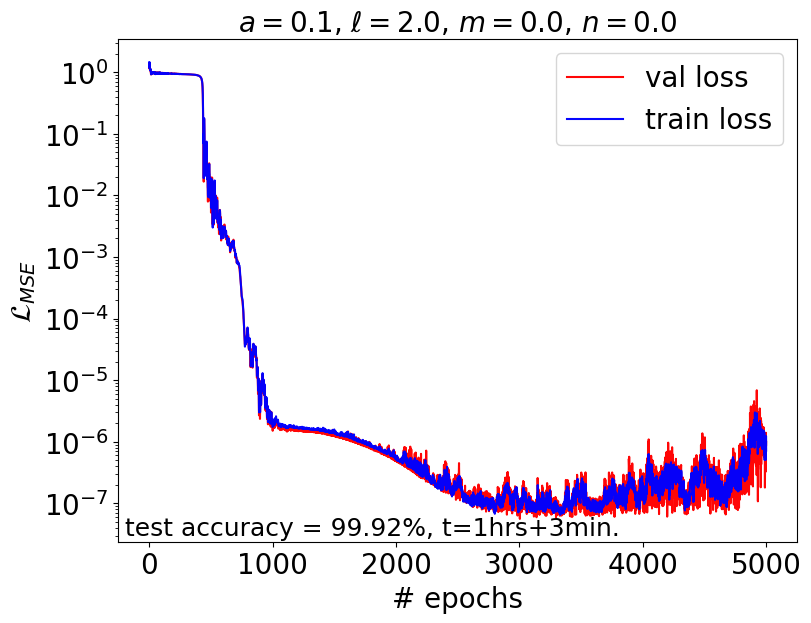

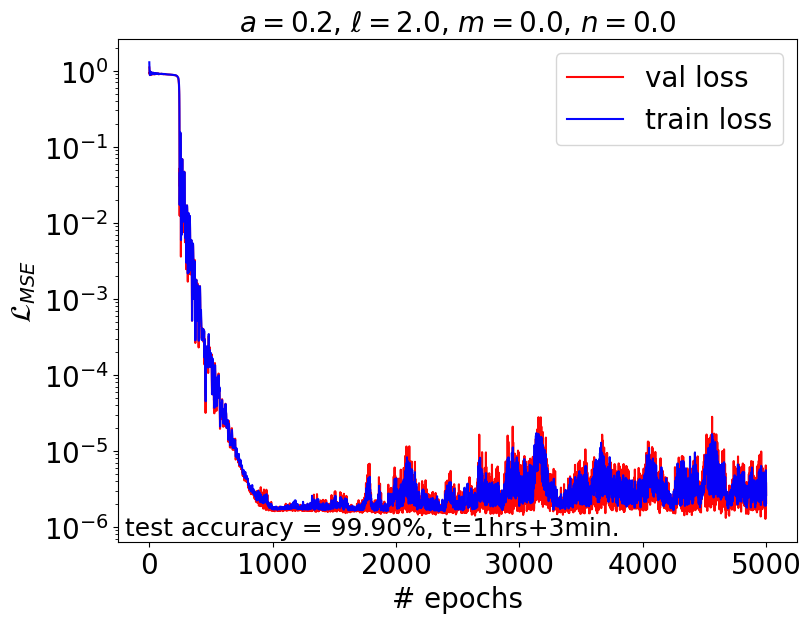

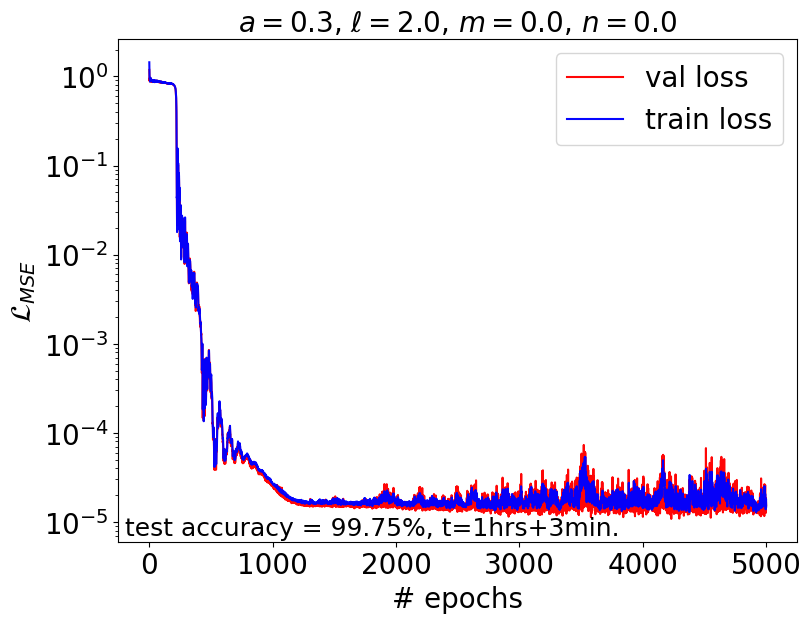

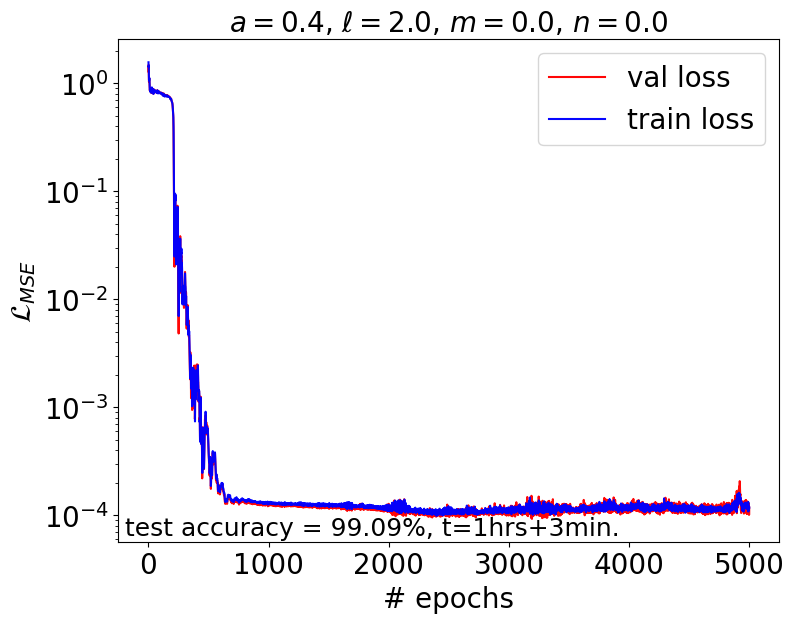

In [ ]:
plot_loss_history(train_loss_dict,
                  val_loss_dict,
                  acc_dict,
                  runtime_dict, size = 20)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# m= 1 missing for a=0.3
a = [0.1, 0.2, 0.4, 0.45, 0.49, 0.4999]
ell = [2.0]
m = [0.0, 1.0]
n = [0.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

f1_res_dict, f2_res_dict, g1_res_dict, g2_res_dict = dict(), dict(), dict(), dict()

for i in range(len(mode)):

    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    f_res = 'RODE_a%sell%sm%sn%s.csv'%(a, ell, m, n)
    f_res = pd.read_csv('gdrive/MyDrive/qnm_data_updated/'+ f_res, names=["x", "f1_res", "f2_res"])

    mask1 = f_res["f1_res"] == 'Indeterminate'
    mask2 = f_res["f2_res"] == 'Indeterminate'

    f_res.loc[mask1, "f1_res"] = 0
    f_res.loc[mask2, "f2_res"] = 0

    f_res = f_res.astype('float32').to_numpy()

    g_res = 'GODE_a%sell%sm%sn%s.csv'%(a, ell, m, n)
    g_res = pd.read_csv('gdrive/MyDrive/qnm_data_updated/'+ g_res, names=["u", "g1_res", "g2_res"])

    mask1 = g_res["g1_res"] == 'Indeterminate'
    mask2 = g_res["g2_res"] == 'Indeterminate'

    g_res.loc[mask1, "g1_res"] = 0
    g_res.loc[mask2, "g2_res"] = 0

    g_res = g_res.astype('float32').to_numpy()

    f1_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(f_res[:, 1:2]).mean()})
    f2_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(f_res[:, 2:3]).mean()})
    g1_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(g_res[:, 1:2]).mean()})
    g2_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(g_res[:, 2:3]).mean()})


def plot_residuals(f1_res_dict,
                   f2_res_dict,
                   g1_res_dict,
                   g2_res_dict,
                   size=18):

    plt.rc('xtick', labelsize=size)
    plt.rcParams.update({'font.size': size})
    plt.rc('font', size=size)
    plt.rc('axes', titlesize=size)
    plt.rc('axes', labelsize=size)
    plt.rc('legend', fontsize=size)

    a_ = [0.1, 0.2, 0.4, 0.45, 0.49, 0.4999]
    f1_res_, f2_res_, g1_res_, g2_res_ = [], [], [], []
    f1_res_1, f2_res_1, g1_res_1, g2_res_1 = [], [], [], []

    for i in a_:
        f1_res_.append(f1_res_dict["a_%s_ell_2.0_m_0.0_n_0.0" %(i)])
        f2_res_.append(f2_res_dict["a_%s_ell_2.0_m_0.0_n_0.0" %(i)])
        g1_res_.append(g1_res_dict["a_%s_ell_2.0_m_0.0_n_0.0" %(i)])
        g2_res_.append(g2_res_dict["a_%s_ell_2.0_m_0.0_n_0.0" %(i)])

        f1_res_1.append(f1_res_dict["a_%s_ell_2.0_m_1.0_n_0.0" %(i)])
        f2_res_1.append(f2_res_dict["a_%s_ell_2.0_m_1.0_n_0.0" %(i)])
        g1_res_1.append(g1_res_dict["a_%s_ell_2.0_m_1.0_n_0.0" %(i)])
        g2_res_1.append(g2_res_dict["a_%s_ell_2.0_m_1.0_n_0.0" %(i)])


    f, ax = plt.subplots(figsize = (8,6))
    plt.plot(a_, f1_res_, '-b', linestyle="-", alpha=0.975, label="$m = 0.0$");
    plt.plot(a_, f2_res_, '-r', linestyle="-", alpha=0.975);

    plt.plot(a_, f1_res_1, '-b', linestyle="--", alpha=0.975, label="$m = 1.0$");
    plt.plot(a_, f2_res_1, '-r', linestyle="--", alpha=0.975);

    f.tight_layout()
    plt.xlabel("$a$")
    plt.xlim(left = 0.1)
    plt.ylabel("$\Delta PDE(r)$")
    plt.yscale("log")
    plt.legend(loc='upper left')
    xticks = [0.1, 0.2, 0.3, 0.4, 0.4999]
    xlabels = ["%s"%(x) for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    plt.title("$a = \{0.1, 0.2, 0.3, 0.4, 0.4, 0.45, 0.49, 0.4999 \}$,\n $\ell = 2.0$, $m = {0.0, 1.0}$, $n = 0$")
    plt.savefig('deltaradialpdespins.pdf', bbox_inches = 'tight')

    f, ax = plt.subplots(figsize = (8,6))

    plt.plot(a_, g1_res_, '-b', linestyle="-", alpha=0.975, label="$m = 0.0$");
    plt.plot(a_, g2_res_, '-r', linestyle="-", alpha=0.975);

    plt.plot(a_, g1_res_1, '-b', linestyle="--", alpha=0.975, label="$m = 1.0$");
    plt.plot(a_, g2_res_1, '-r', linestyle="--", alpha=0.975);

    f.tight_layout()
    plt.xlabel("$a$")
    plt.ylabel("$\Delta PDE(\\theta)$")
    plt.xlim(left = 0.1)
    plt.yscale("log")
    plt.legend(loc='upper left')
    xticks = [0.1, 0.2, 0.3, 0.4, 0.4999]
    xlabels = ["%s"%(x) for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    plt.title("$a = \{0.1, 0.2, 0.3, 0.4, 0.4, 0.45, 0.49, 0.4999 \}$,\n $\ell = 2.0$, $m = {0.0, 1.0}$, $n = 0$")
    plt.savefig('deltaangularpdespins.pdf', bbox_inches = 'tight')

In [ ]:
plot_residuals(f1_res_dict,
              f2_res_dict,
              g1_res_dict,
              g2_res_dict,
              size=18)

# extra plots

In [ ]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# just a excessively big function for adding arrows to the curve :)
def add_arrow_to_line2D(
    axes, line, arrow_locs=[0.2, 0.4, 0.6, 0.8],
    arrowstyle='-|>', arrowsize=2, transform=None):
    """
    Add arrows to a matplotlib.lines.Line2D at selected locations.

    Parameters:
    -----------
    axes:
    line: Line2D object as returned by plot command
    arrow_locs: list of locations where to insert arrows, % of total length
    arrowstyle: style of the arrow
    arrowsize: size of the arrow
    transform: a matplotlib transform instance, default to data coordinates

    Returns:
    --------
    arrows: list of arrows
    """
    if not isinstance(line, mlines.Line2D):
        raise ValueError("expected a matplotlib.lines.Line2D object")
    x, y = line.get_xdata(), line.get_ydata()

    arrow_kw = {
        "arrowstyle": arrowstyle,
        "mutation_scale": 10 * arrowsize,
    }

    color = line.get_color()
    use_multicolor_lines = isinstance(color, np.ndarray)
    if use_multicolor_lines:
        raise NotImplementedError("multicolor lines not supported")
    else:
        arrow_kw['color'] = color

    linewidth = line.get_linewidth()
    if isinstance(linewidth, np.ndarray):
        raise NotImplementedError("multiwidth lines not supported")
    else:
        arrow_kw['linewidth'] = linewidth

    if transform is None:
        transform = axes.transData

    arrows = []
    for loc in arrow_locs:
        s = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
        n = np.searchsorted(s, s[-1] * loc)
        arrow_tail = (x[n], y[n])
        arrow_head = (np.mean(x[n:n + 2]), np.mean(y[n:n + 2]))
        p = mpatches.FancyArrowPatch(
            arrow_tail, arrow_head, transform=transform,
            **arrow_kw)
        axes.add_patch(p)
        arrows.append(p)
    return arrows

def kerr_2Dplots(omega1, err1, omega2, err2, A1, err3, A2, err4, omega, A, a, ell, m, n, runtime):

  size = 15
  plt.rc('xtick', labelsize=16)
  plt.rcParams.update({'font.size': 16})
  plt.rc('font', size=size)
  plt.rc('axes', titlesize=size)
  plt.rc('axes', labelsize=size)
  plt.rc('legend', fontsize=size)
  plt.rcParams['legend.loc'] = "upper right"

  # plots for the quasinormal mode frequencies

  f, ax = plt.subplots(figsize = (8,6))

  if omega1[-1] > 0 and omega2[-1] > 0:
    line1, = plt.plot(np.array(omega2)*(-1), np.array(omega1)*(1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(1)) + 0.25)

  elif omega1[-1] < 0 and omega2[-1] < 0:
    line1, = plt.plot(np.array(omega2), np.array(omega1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(-1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(-1)) + 0.25)

  elif omega1[-1] < 0 and omega2[-1] > 0:
    line1, = plt.plot(np.array(omega2)*(-1), np.array(omega1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(-1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(-1)) + 0.25)

  elif omega1[-1] > 0 and omega2[-1] < 0:
    line1, = plt.plot(np.array(omega2)*(1), np.array(omega1)*(1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(1)) + 0.25)

  plt.scatter(omega.imag, omega.real, c="r", alpha=1, marker=r'x', label = 'CFM: $\omega_{n}$ = %.6f - %.6fj' %(abs(omega.real), abs(omega.imag)), zorder=2)

  plt.legend()
  text = 's. PINN: $\omega_{n}$ = %.6f - %.6fj (%.3f%%, %.3f%%)\n runtime %.1f minutes' %(abs(omega1[-1]), abs(omega2[-1]), err1[-1], err2[-1], round(runtime/60))
  plt.text(.01, .1, text, size= 14, ha='left', va='top', transform=ax.transAxes)
  plt.title("$s$=-2, $a$={}, $\ell$={}, $m$={}, $n$={}".format(a, ell, m, n))
  plt.ylabel('Re[$\omega_{n}$]');plt.xlabel('Im[$\omega_{n}$]')
  plt.savefig("omega_s-2.0_a{}_ell{}_m{}_n{}.pdf".format(a, ell, m, n), bbox_inches='tight')

  # plots for the separation constants

  f, ax = plt.subplots(figsize = (8,6))

  if A1[-1] > 0 and A2[-1] > 0:
    line, = plt.plot(np.array(A2), np.array(A1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)) - 0.5)
    plt.plot(0, max(np.array(A1)) + 0.5)

  elif A1[-1] < 0 and A2[-1] < 0:
    line, = plt.plot(np.array(A2)*(-1), np.array(A1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)*(-1)) - 0.5)
    plt.plot(0, max(np.array(A1)*(-1)) + 0.5)

  elif A1[-1] < 0 and A2[-1] > 0:
    line, = plt.plot(np.array(A2), np.array(A1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)*(-1)) - 0.5)
    plt.plot(0, max(np.array(A1)*(-1)) + 0.5)

  elif A1[-1] > 0 and A2[-1] < 0:
    line, = plt.plot(np.array(A2)*(-1), np.array(A1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)) - 0.5)
    plt.plot(0, max(np.array(A1)) + 0.5)


  plt.scatter(A.imag, A.real, c="r", alpha=1, marker=r'x', label = 'CFM: $A_{\ell m}$ = %.6f + %.6fj' %(abs(A.real), abs(A.imag)), zorder=2)

  plt.legend()
  text = 'PINN: $A_{\ell m}$ = %.6f + %.6fj (%.3f%%, %.3f%%)\n runtime %.1f minutes' %(abs(A1[-1]), abs(A2[-1]), err3[-1], err4[-1], round(runtime/60))
  plt.text(.01, .1, text, size= 14, ha='left', va='top', transform=ax.transAxes)
  plt.title("$s$=-2, $a$={}, $\ell$={}, $m$={}, $n$={}".format(a, ell, m, n))
  plt.ylabel('Re[$A_{\ell m}$]');plt.xlabel('Im[$A_{\ell m}$]')
  plt.savefig("A_s-2.0_a{}_ell{}_m{}_n{}.pdf".format(a, ell, m, n), bbox_inches='tight')

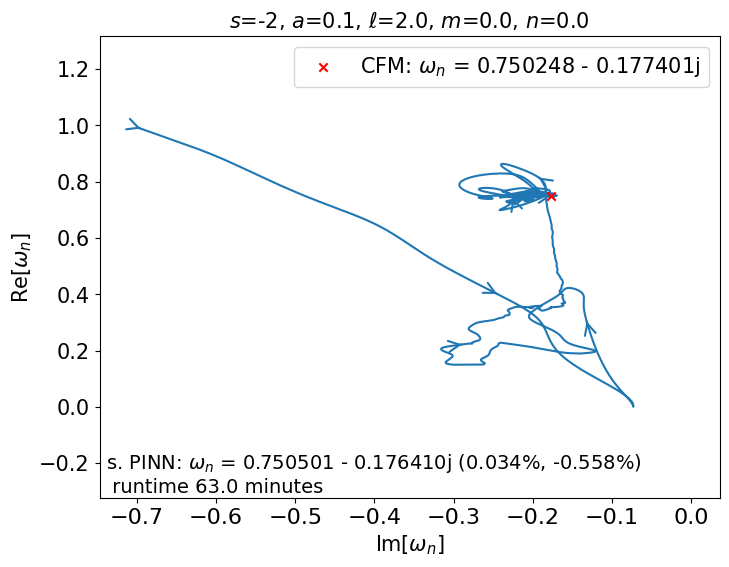

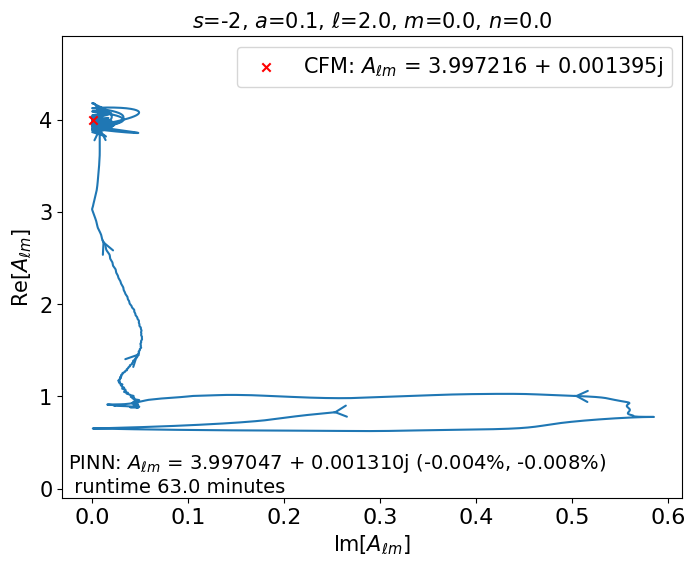

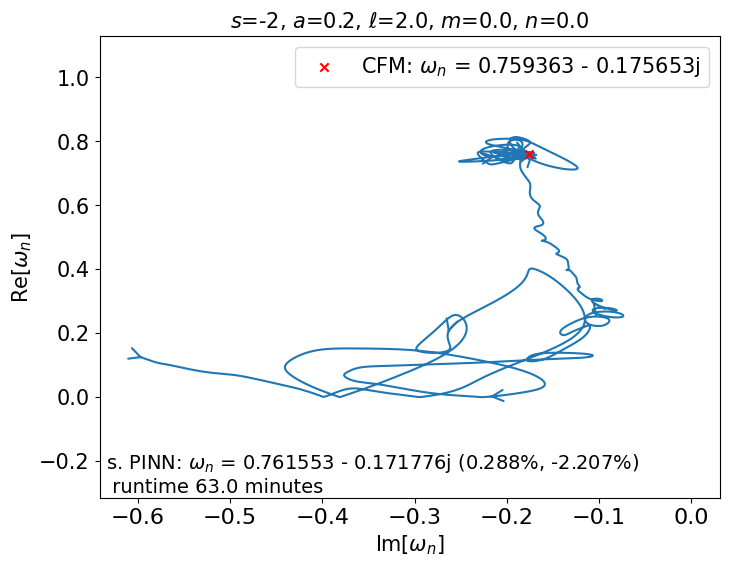

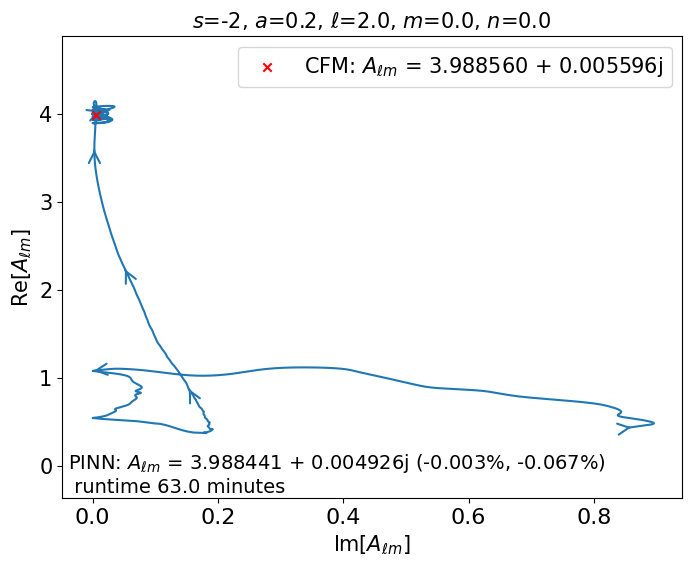

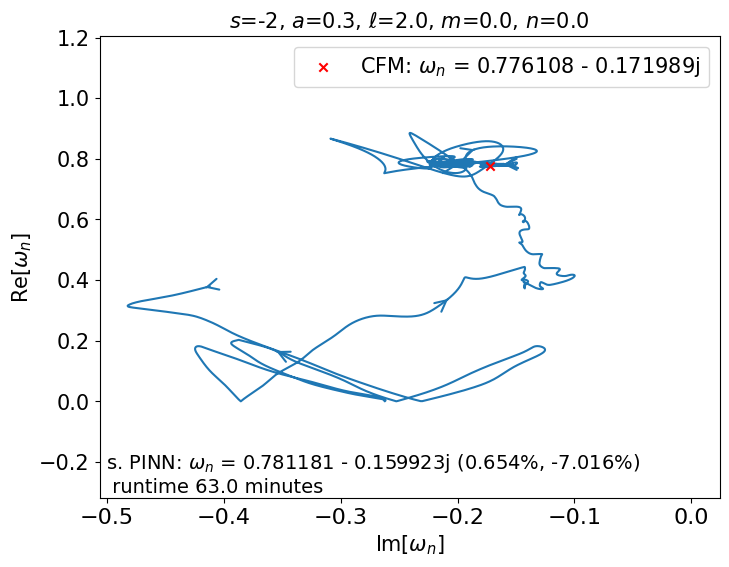

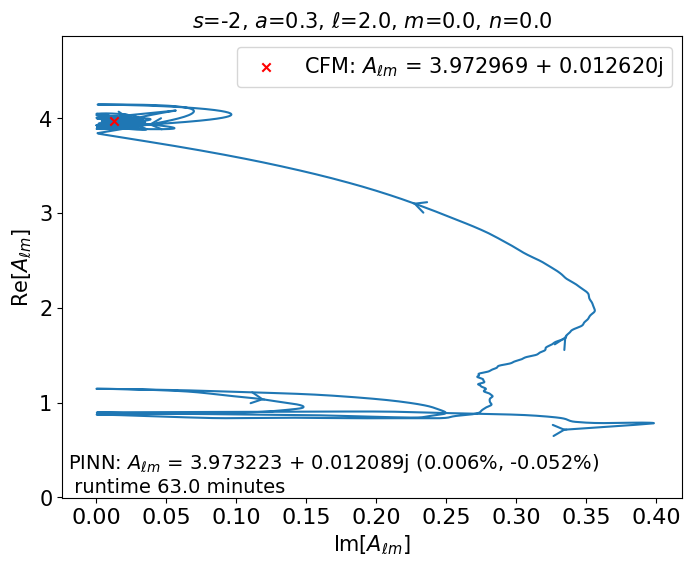

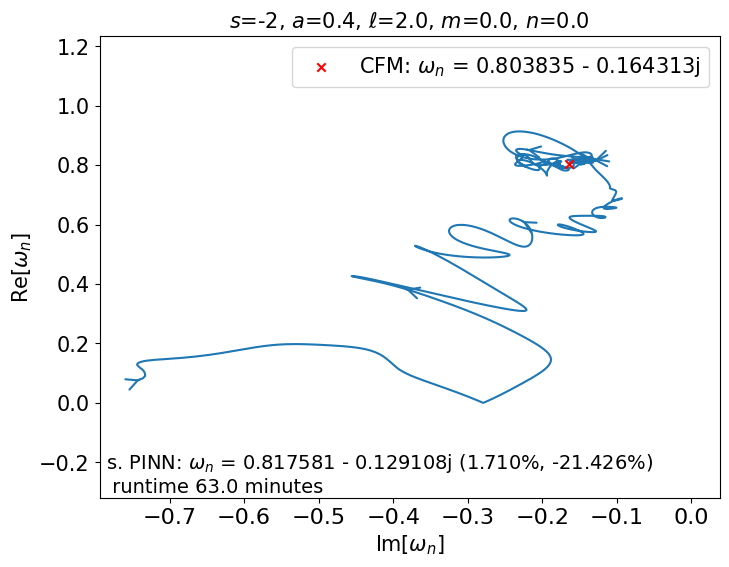

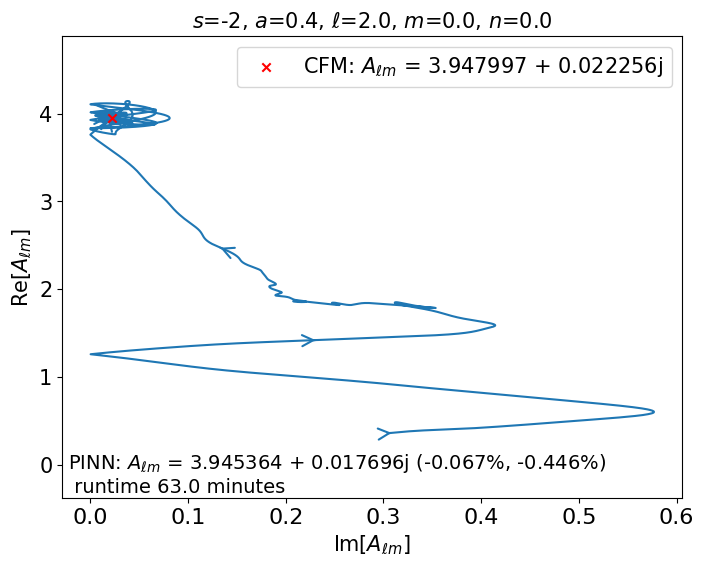

In [ ]:
s = -2
a = [0.1, 0.2, 0.3, 0.4]
ell = [2.0]
m = [0.0]
n = [0.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

for i in range(len(mode)):

    s = -2
    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    spin_sequence_slmn = qnm.modes_cache(s=int(s), l=int(ell), m=int(m), n=int(n))
    omega_, A_, _ = spin_sequence_slmn(a=a*2)

    kerr_2Dplots(
    omega1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    omega2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    A1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err3_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    A2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err4_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    omega_*2,
    A_,
    a, ell, m, n,
    runtime_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)])